In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
import os
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.font_manager as fm
import tabulate
import scipy.stats
import networkx as nx
import itertools
from sklearn import metrics
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.patches as mpatches
import sklearn.neighbors
from scipy.spatial import distance
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import Counter
import skimage
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io
import numpy as np
import gget
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import utils as ut

from mpl_toolkits.mplot3d import Axes3D



In [2]:
# upload the scale factors

keys = ['ND', 'HFD8', 'HFD14']

scales = []

for key in keys:
    path = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/{key}/outs/spatial/scalefactors_json.json"
    
    tmp = pd.read_json(path, lines=True)
    tmp['key'] = key
    # tmp['lowres_spot_diameter_pixels'] = tmp['spot_diameter_fullres'] * tmp['tissue_lowres_scalef']
    # tmp['lowres_spot_diameter_units'] = tmp['lowres_spot_diameter_pixels'] * 65
    
    scales.append(tmp)
    
scales = pd.concat(scales, ignore_index=True)
print(scales)
# print(scales[['key', 'spot_diameter_fullres', 'lowres_spot_diameter_pixels']])


def getscalebar(key, length, scales=scales):
    """Length is physical units """
    lookup = scales.loc[scales['key'] == key]
    pixels = lookup['spot_diameter_fullres'].values[0]
    scaleFactor = lookup['tissue_lowres_scalef'].values[0]
    units = 65 # mircons
    
    fullResPixels = (pixels * length) / units
    lowResPixels = fullResPixels * scaleFactor
    
    return lowResPixels
    
getscalebar('ND', length=100)

   spot_diameter_fullres  tissue_hires_scalef  fiducial_diameter_fullres  \
0             257.195160             0.050684                 415.469120   
1             257.368127             0.051089                 415.748513   
2             257.404844             0.049124                 415.807825   

   tissue_lowres_scalef    key  
0              0.015205     ND  
1              0.015327   HFD8  
2              0.014737  HFD14  


6.016495945974647

In [3]:
getscalebar('ND', 100)

6.016495945974647

In [4]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/lowres/"


lowres = {}

for f in os.listdir(imDir):
    if f.endswith("png"):
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = f.replace(".png", "")
        print(key, img.shape)
        lowres[key] = img

print('done')

HFD14 (2000, 1628)
ND (2000, 1681)
HFD8 (2000, 1692)
done


In [5]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath)
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


Pair.Name Ligand.Mouse Receptor.Mouse      Source ManualAnnotation  \
0          A2m-Lrp1          A2m           Lrp1  Ramilowski          Correct   
1       Adgre5-Cd55       Adgre5           Cd55      Baccin          Correct   
2    Adipoq-Adipor1       Adipoq        Adipor1  Ramilowski          Correct   
3    Adipoq-Adipor2       Adipoq        Adipor2  Ramilowski          Correct   
4  Adm-Calcrl&Ramp2          Adm   Calcrl&Ramp2      Baccin          Correct   

  Ligand.CC Ligand.GO     Reference (PMID / KEGG)  ligand      receptor  
0  Secreted     Other  1702392,10652313, 12194978     A2M          LRP1  
1  Membrane     Other                    23447688  ADGRE5          CD55  
2  Secreted     Other                    12802337  ADIPOQ       ADIPOR1  
3  Secreted     Other          12802337, 12802330  ADIPOQ       ADIPOR2  
4  Secreted     Other                    10342881     ADM  CALCRL&RAMP2

In [6]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

done


In [7]:
ut.ncolor(4, cmap="Reds")

['#fff5f0', '#fca082', '#e32f27', '#67000d']

key    Condition     N  percTotal      Mac1      Mac3      Mac4  \
0     ND  Macrophages   359   1.000000  0.378830  0.501393  0.041783   
1     ND        Trem2   119   0.331476  0.689076  0.058824  0.092437   
2     ND   Trem2Itgax    15   0.041783  0.133333  0.133333  0.466667   
3   HFD8  Macrophages  2188   1.000000  0.145338  0.237660  0.281536   
4   HFD8        Trem2  1295   0.591865  0.147490  0.074903  0.432432   
5   HFD8   Trem2Itgax   592   0.270567  0.027027  0.092905  0.396959   
6  HFD14  Macrophages  3884   1.000000  0.131308  0.014676  0.363800   
7  HFD14        Trem2  3660   0.942327  0.114481  0.010383  0.359290   
8  HFD14   Trem2Itgax  1406   0.361998  0.013514  0.010669  0.197724   

       Mac2      Mac5  
0  0.069638  0.011142  
1  0.126050  0.033613  
2  0.133333  0.133333  
3  0.185558  0.152651  
4  0.090347  0.257915  
5  0.045608  0.444257  
6  0.009269  0.483265  
7  0.005464  0.512842  
8  0.003556  0.778094

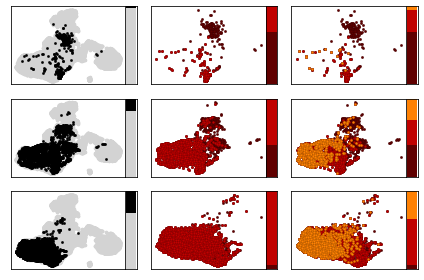

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 9

res = []

fig, axs = plt.subplots(3, 3)
size = 7
colors = ut.ncolor(5, cmap="gist_heat")


for i, key in enumerate(keys):
    rf = rna[key]
    lf = labels[key]
    
    mask = (xy['cellTypes'] == 'Macrophages') & (xy['key'] == key)
    
    # plot macoprophages
    axs[i, 0].scatter(xy['x'][mask], 
                      xy['y'][mask], 
                      ec='k',
                      lw=0.1,
                      s=size,
                      c=colors[0], 
                      zorder=2)
    
    # plot non macoprophages
    axs[i, 0].scatter(xy['x'][~mask], 
                      xy['y'][~mask], 
                      ec='lightgrey',
                      c='lightgrey', 
                      s=size,
                      zorder=1)
    
    axs[i, 0].set_yticks([])
    axs[i, 0].set_xticks([])
    # axs[i, 0].set_ylabel("UMAP 2")
    # axs[i, 0].set_ylabel(f"{key}")
    # axs[i, 0].set_xlabel("UMAP 1")
    # axs[i, 0].set_title(f"{key} Macrophages")
    
    ax_divider = make_axes_locatable(axs[i, 0])
    ax2 = ax_divider.append_axes("right", 
                                 size="10%", 
                                 pad=f"0%")
    
    
    bottom = len(mask) - mask.sum()
    ax2.bar("prop", 
            bottom, 
            color="lightgrey")
    
    ax2.bar("prop", 
            mask.sum(), 
            color=colors[0],
            bottom=bottom)
    
    ax2.set_ylim([0, len(mask)])
    ax2.set_yticks([])
    # ax2.set_ylabel("Proportion of Cells")
    ax2.yaxis.set_label_position("right")
    ax2.set_xticks([])

    """ plot TREM2+ macrophages """
    tremPos = rf['TREM2'].astype(bool)
    tremPosIds = (tremPos > 0)
    tremPosIds = rf[tremPosIds].index.to_list()
    newMask = (xy['cellTypes'] == 'Macrophages') & (xy['key'] == key) & (xy['cellId'].isin(tremPosIds))
        
    axs[i, 1].scatter(xy['x'][newMask], 
                      xy['y'][newMask], 
                      ec='k',
                      lw=0.1,
                      c=colors[2], 
                      s=size,
                      zorder=3)
    
    axs[i, 1].scatter(xy['x'][mask], 
                      xy['y'][mask], 
                      ec='k',
                      lw=0.1,
                      c=colors[1], 
                      s=size,
                      zorder=2)
    
    # axs[i, 1].scatter(xy['x'][~mask], 
    #                   xy['y'][~mask], 
    #                   ec='lightgrey',
    #                   c='lightgrey', 
    #                   s=20,
    #                   zorder=1)
    
    axs[i, 1].set_yticks([])
    axs[i, 1].set_xticks([])
    # axs[i, 1].set_xlabel("UMAP 1")
    # axs[i, 1].set_title(f"Trem2+")
    
    
    ax_divider = make_axes_locatable(axs[i, 1])
    ax2 = ax_divider.append_axes("right", 
                                 size="10%", 
                                 pad=f"0%")
    
    bottom = mask.sum() - newMask.sum()
    ax2.bar("prop", 
            bottom, 
            color=colors[1])
    
    ax2.bar("prop", 
            newMask.sum(), 
            color=colors[2],
            bottom=bottom)
    
    ax2.set_ylim([0, mask.sum()])
    ax2.set_yticks([])
    # ax2.set_ylabel("Proportion of Macrophages")
    ax2.yaxis.set_label_position("right")
    ax2.set_xticks([])
    
    
    """ plot TREM2+ macrophages """
    Pos = rf[['ITGAX', 'TREM2']].astype(bool).sum(axis=1)
    posIds = (Pos > 1)
    
    posIds = rf[posIds].index.to_list()
    
    newnewMask = (xy['cellTypes'] == 'Macrophages') & (xy['key'] == key) & (xy['cellId'].isin(posIds))
        
    axs[i, 2].scatter(xy['x'][newnewMask], 
                      xy['y'][newnewMask], 
                      ec='k',
                      c=colors[3], 
                      lw=0.1,
                      s=size,
                      zorder=4)
    
    axs[i, 2].scatter(xy['x'][newMask], 
                      xy['y'][newMask], 
                      ec='k',
                      lw=0.1,
                      c=colors[2], 
                      s=size,
                      zorder=3)
    
    axs[i, 2].scatter(xy['x'][mask], 
                      xy['y'][mask], 
                      ec='k',
                      lw=0.1,
                      c=colors[1], 
                      s=size,
                      zorder=2)
    
    # axs[i, 2].scatter(xy['x'][~mask], 
    #                   xy['y'][~mask], 
    #                   ec='lightgrey',
    #                   c='lightgrey', 
    #                   s=20,
    #                   zorder=1)
    axs[i, 2].set_yticks([])
    axs[i, 2].set_xticks([])
    # axs[i, 2].set_xlabel("UMAP 1")
    # axs[i, 2].set_title(f"Trem2+ and Cd11c+")
    
    
    ax_divider = make_axes_locatable(axs[i, 2])
    ax2 = ax_divider.append_axes("right", 
                                 size="10%", 
                                 pad=f"0%")
    
    bottom = mask.sum() - newMask.sum()
    ax2.bar("prop", 
            bottom, 
            color=colors[1])
    
    bottom2 = newMask.sum() - newnewMask.sum()
    ax2.bar("prop", 
            bottom2, 
            color=colors[2],
            bottom=bottom)
    
    ax2.bar("prop", 
            newnewMask.sum(), 
            color=colors[3],
            bottom=bottom2+bottom)
    
    
    ax2.set_ylim([0, mask.sum()])
    ax2.set_yticks([])
    # ax2.set_ylabel("Proportion of Macrophages")
    ax2.yaxis.set_label_position("right")
    ax2.set_xticks([])
    
    conds = {
        "Macrophages" : mask,
        "Trem2" : newMask,
        "Trem2Itgax" : newnewMask,
    }
    
    for k, v in conds.items():
        
        sub = lf[lf['cellId'].isin(xy[v]['cellId'])]['cellType'].to_list()
        n = v.sum()
        sub = Counter(sub)
        
        row = {
            'key' : key,
            'Condition' : k,
            'N' : n,
            'percTotal' : n / conds['Macrophages'].sum()
        }
        
        for ct, nct in sub.items():
            row[ct] = nct / n
        res.append(row)

    
    # break
    
    
plt.tight_layout()

res = pd.DataFrame(res)
res

In [9]:
res.head()

key    Condition     N  percTotal      Mac1      Mac3      Mac4      Mac2  \
0    ND  Macrophages   359   1.000000  0.378830  0.501393  0.041783  0.069638   
1    ND        Trem2   119   0.331476  0.689076  0.058824  0.092437  0.126050   
2    ND   Trem2Itgax    15   0.041783  0.133333  0.133333  0.466667  0.133333   
3  HFD8  Macrophages  2188   1.000000  0.145338  0.237660  0.281536  0.185558   
4  HFD8        Trem2  1295   0.591865  0.147490  0.074903  0.432432  0.090347   

       Mac5  
0  0.011142  
1  0.033613  
2  0.133333  
3  0.152651  
4  0.257915

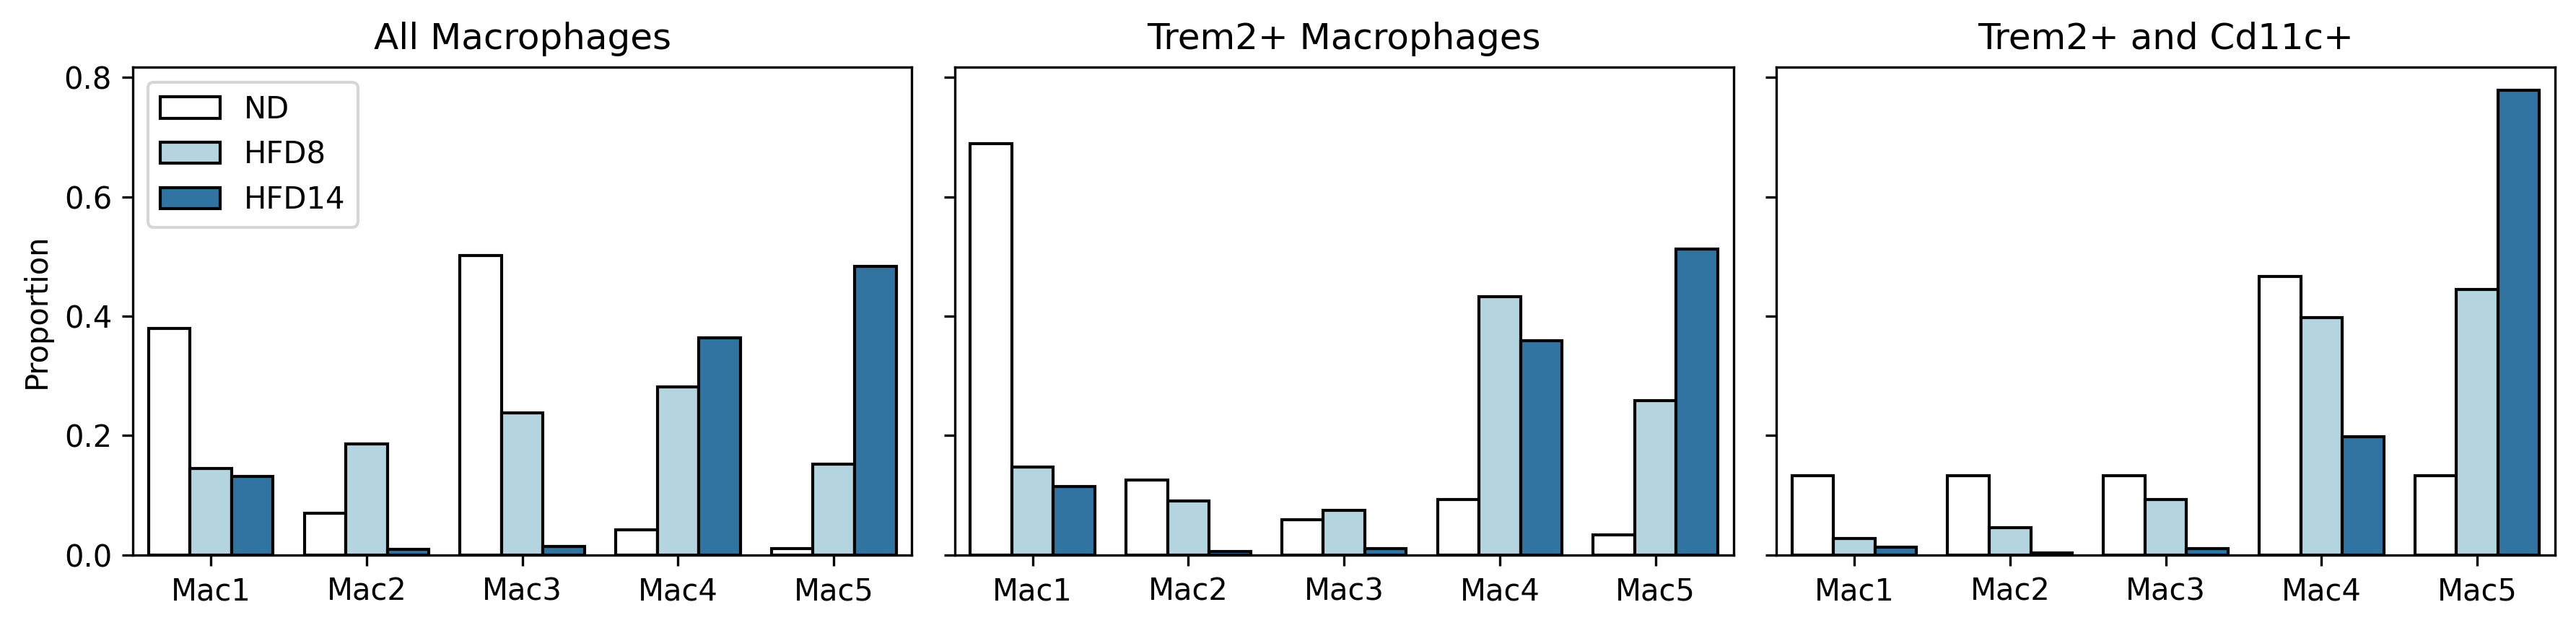

In [10]:
p = pd.melt(res, id_vars=['key', 'Condition'], value_vars=['Mac1','Mac3', 'Mac4', 'Mac2', 'Mac5'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 3

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()


pltLabels = [
    'All Macrophages',
    'Trem2+ Macrophages',
    'Trem2+ and Cd11c+',
]


for i, cond in enumerate(p['Condition'].unique()):
    
    ptemp = p[p['Condition'] == cond]
    ptemp = ptemp.sort_values(by=['key', 'variable'], ascending=[False, True])
    
    sns.barplot(data=ptemp, 
                x='variable', 
                y='value',
                edgecolor='k',
                hue='key', 
                palette=['white', 'lightblue', 'C0'],
                ax=axs[i])
    if i == 0:
        axs[i].legend(loc='upper left')
    else:
        axs[i].legend().remove()
        
    axs[i].set_xlabel("")
    if i == 0:
        axs[i].set_ylabel("Proportion")
    else:
        axs[i].set_ylabel("")
        
    axs[i].set_title(pltLabels[i])

plt.tight_layout()

In [11]:
# break

# Spatial Networks

In [12]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'macrophage' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(14836, 13)
HFD8     6782
ND       4068
HFD14    3986
Name: key, dtype: int64



spotId  Dendritic cells      Mac4  Stromal cells  NK cells  \
0  AAACAAGTATCTCCCA.1         0.087213  0.113186       0.270488  0.096431   
1  AAACACCAATAACTGC.1         0.159247  0.129071       0.105884  0.002606   
2  AAACAGCTTTCAGAAG.1         0.042437  0.128286       0.329050  0.064440   
3  AAACAGGGTCTATATT.1         0.038153  0.094966       0.294255  0.055503   
4  AAACAGTGTTCCTGGG.1         0.000020  0.256841       0.323585  0.003329   

       Mac2  Monocytes   T cells      Mac5      Mac3      Mac1   B cells   key  
0  0.057255   0.083130  0.047384  0.163491  0.049659  0.006606  0.025157  HFD8  
1  0.084753   0.088446  0.016601  0.302068  0.046115  0.038813  0.026395  HFD8  
2  0.050805   0.049080  0.052493  0.100578  0.065773  0.025274  0.091783  HFD8  
3  0.061959   0.060107  0.048176  0.127678  0.099188  0.040547  0.079468  HFD8  
4  0.015668   0.010229  0.002518  0.222850  0.000587  0.000737  0.163636  HFD8

In [13]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

normalize = True

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        if normalize:
            sdf = ut.normalize(sdf)
        spt[key] = sdf
    
print('done')

HFD8_macrophage_spt.csv
HFD14_macrophage_spt.csv
ND_macrophage_spt.csv
done


In [14]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(14848, 4)
HFD8     6788
ND       4072
HFD14    3988
Name: key, dtype: int64



spotId            x            y    key
0  AAACATTTCCCGGATT.1  1139.783401  1365.804581  HFD14
1  AAACCGGGTAGGTACC.1   468.056902  1045.415505  HFD14
2  AAACCGTTCGTCCAGG.1   604.524374  1214.452428  HFD14
3  AAACCTAAGCAGCCGG.1  1003.708924  1433.743571  HFD14
4  AAACCTCATGAAGTTG.1   380.369919   960.970730  HFD14

In [15]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

HFD8     3394
ND       2036
HFD14    1994
Name: key, dtype: int64


spotId            x            y    key  Dendritic cells  \
0  AAACATTTCCCGGATT.1  1139.783401  1365.804581  HFD14     3.468007e-02   
2  AAACCGGGTAGGTACC.1   468.056902  1045.415505  HFD14     1.280364e-03   
4  AAACCGTTCGTCCAGG.1   604.524374  1214.452428  HFD14     3.752028e-04   
6  AAACCTAAGCAGCCGG.1  1003.708924  1433.743571  HFD14     1.198581e-07   
8  AAACCTCATGAAGTTG.1   380.369919   960.970730  HFD14     1.377525e-02   

       Mac4  Stromal cells  NK cells      Mac2  Monocytes   T cells      Mac5  \
0  0.007548       0.409201  0.170860  0.004757   0.041542  0.055275  0.219997   
2  0.088368       0.187514  0.019633  0.028867   0.129969  0.040070  0.450618   
4  0.004256       0.283055  0.187004  0.021560   0.108340  0.044845  0.310869   
6  0.009084       0.239973  0.043516  0.004948   0.057287  0.052469  0.558332   
8  0.029749       0.216199  0.122802  0.053188   0.158933  0.041466  0.234411   

       Mac3      Mac1   B cells  
0  0.010912  0.004188  0.041040  
2  0.008903  0.013757  0.031021  
4  0.003200  0.004016  0.032480  
6  0.000064  0.023214  0.011113  
8  0.043126  0.037127  0.049224

In [16]:
def closest_node(node, nodes, metric):
    closest_index = distance.cdist([node], nodes, metric=metric).argmin()
    return closest_index

def getGraph(kdf, x, y, n=300, metric='minkowski', return_center=True):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    nodes = kdf[['x', 'y']]
    centerInd = closest_node([x, y], nodes, metric)
    
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=n,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    
    # create the subgraph
    windowIndices = indices[centerInd]
    mask = kdf.index.isin(windowIndices)
    
    center = kdf[mask].reset_index(drop=True)
    dists = sklearn.metrics.pairwise_distances(center[['x', 'y']], metric=metric)
    
    X = dists
    
    # create the graph
    nodeMapper = dict(zip(center.index, center['spotId']))
    G = nx.from_numpy_array(X)
    G = nx.relabel_nodes(G, nodeMapper)
    
    # set positions
    pos = {}
    for idx, row in center.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    
    if return_center:
        return G, center
    else:
        return G
    
    
def getKnn(kdf, k=6, metric='minkowski'):
    """A function to generate a knn graph """
    
    nodes = kdf[['x', 'y']]
      
    # get the n points around that node
    nbrs = NearestNeighbors(n_neighbors=k+1,  
                            metric=metric, 
                            algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    return indices


def knnInd2Id(kdf, knnInd):
    """Translate neighbors to spotIds """
    
    transId = {}
    
    for i, row in kdf.iterrows():
        spotId = row['spotId']
        nbrhs = kdf.iloc[knnInd[i]]['spotId'].values
        transId[spotId] = nbrhs
    return transId
    
    

def blur(sdf, transId):
    """A function to blur all columns using their neighbors.
    Expects spotIds as index """
    
    results  = []
    
    for spotId, nbhs in transId.items():
        
        t = sdf.loc[nbhs].mean().to_dict()
        t['spotId'] = spotId
        results.append(t)
        
    results = pd.DataFrame(results)
    results = results.set_index('spotId')
    return results

In [17]:
keys = ['ND', 'HFD8', 'HFD14']
graph = {}
meta = {}

n = 300

for i, key in enumerate(keys):
    kdf = df[df['key'] == key].reset_index(drop=True)
    # get the center node index
    x = kdf['x'].mean()
    y = kdf['y'].mean()
    
    G, mf = getGraph(kdf, x, y, n)
    graph[key] = G
    meta[key] = mf
    
print('done')

done


In [18]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 6, 6

# n = 200
# key = "HFD8"
# kdf = df[df['key'] == key].reset_index(drop=True)
# # get the center node index
# x = kdf['x'].mean()
# y = kdf['y'].mean()

# G, mf = getGraph(kdf, x, y, n)


# mask = kdf['spotId'].isin(mf['spotId'])

# plt.scatter(kdf['x'][mask],
#             kdf['y'][mask], 
#             c='r',
#             ec='k',
#             zorder=2,
#             lw=0.5,
#             s=15,
#            )


# # plt.scatter(x, y, 
# #             s=6000, 
# #             c='r',
# #             alpha=0.5, 
# #             zorder=2,)

# plt.scatter(kdf['x'][~mask],
#             kdf['y'][~mask], 
#             c='lightgrey',
#             zorder=1,
#             s=15,
#            )

# ax = plt.gca()
# ax.set_aspect('equal')
# ax.invert_yaxis()
# ax.set_title(f"{key}")
# ax.set_xticks([])
# ax.set_yticks([])

==== ND ====
	Density: 0.0000
	Number of nodes in largest cc: 1.0000 (0.0033)
==== HFD8 ====
	Density: 0.0011
	Number of nodes in largest cc: 9.0000 (0.0300)
==== HFD14 ====
	Density: 0.0050
	Number of nodes in largest cc: 109.0000 (0.3633)


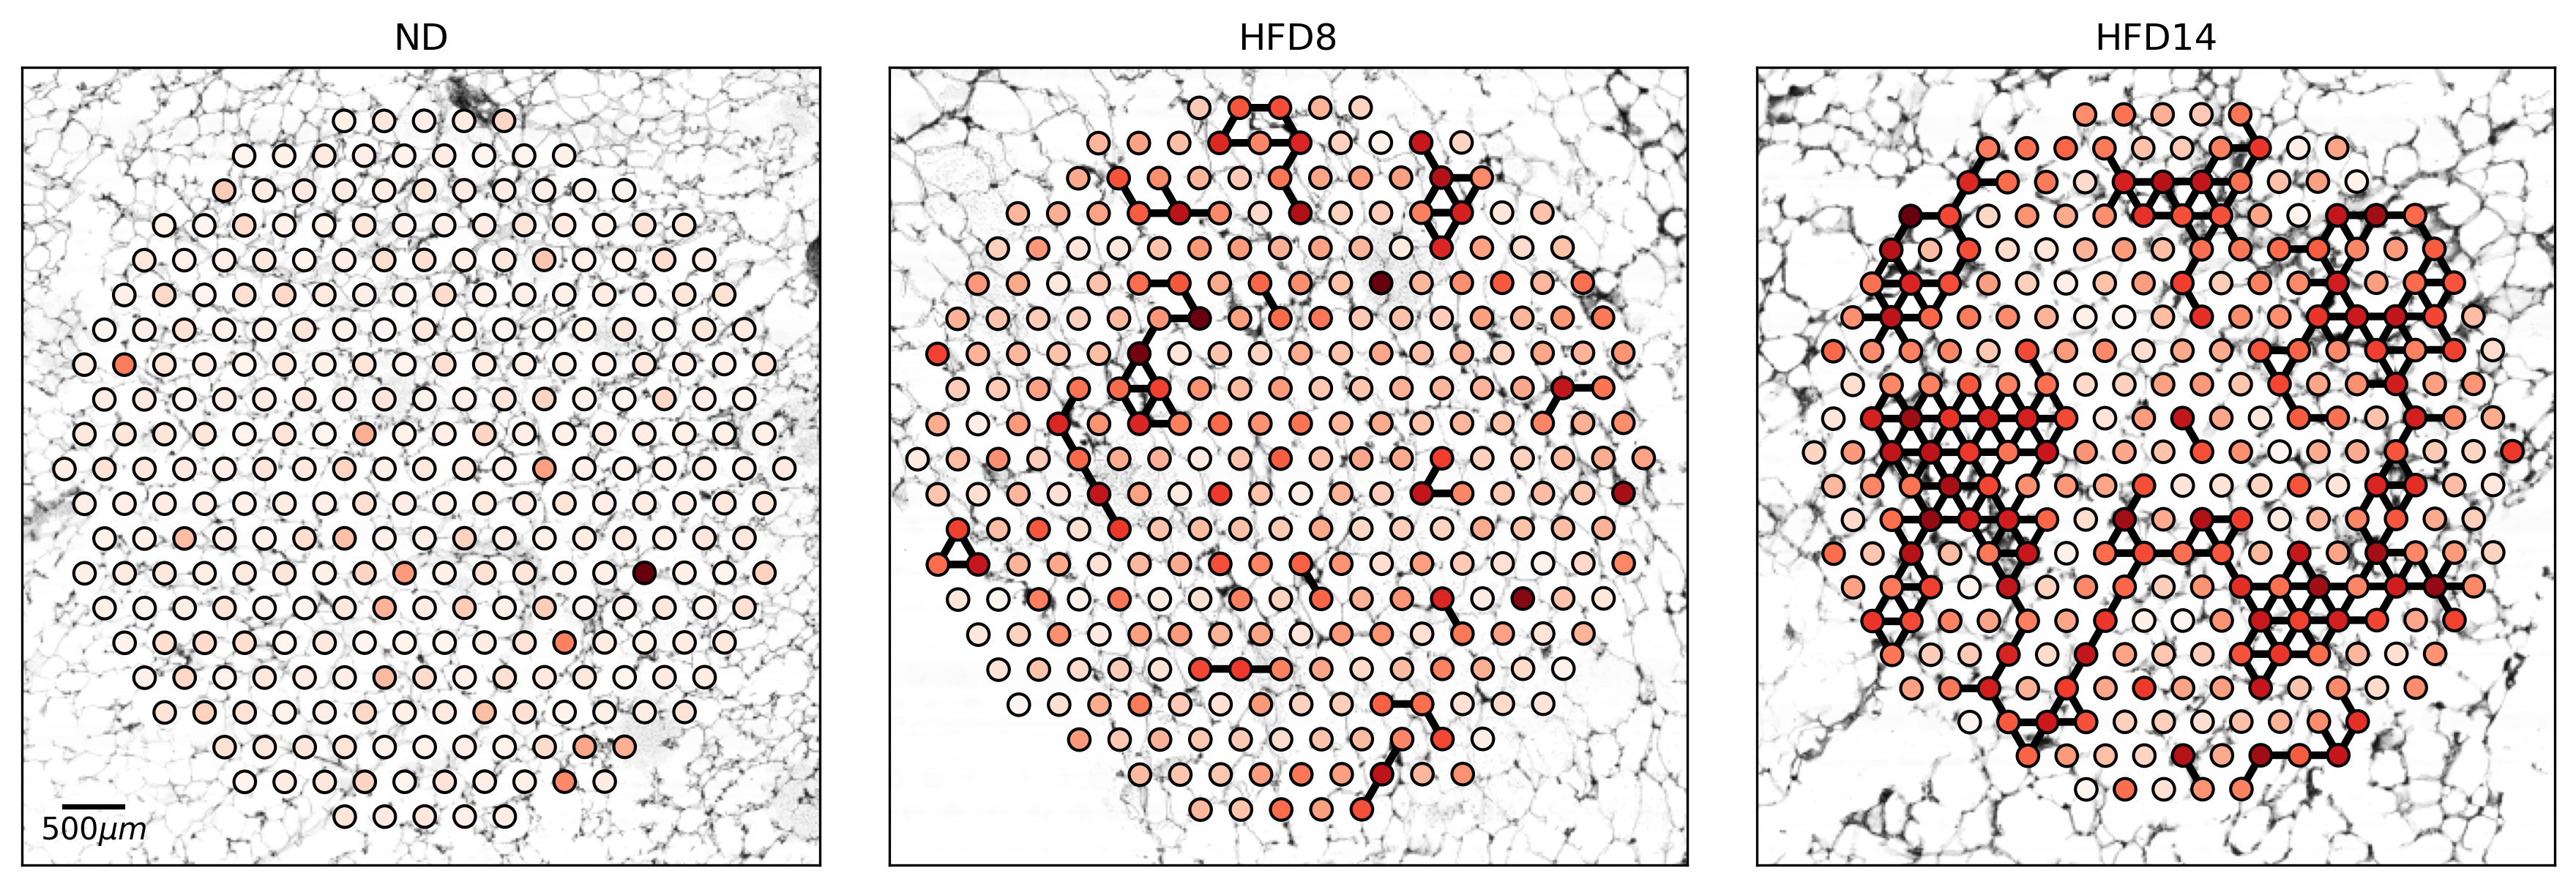

In [19]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 3, 9
plt.rcParams['figure.figsize'] = 12, 4

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

pway = {}

plotBox = 400
radius = 25
cmap = 'Reds'
t = 0.5

for i, key in enumerate(keys):
    
    G = graph[key]
    mf = meta[key]

    mf['norm'] = mf['Mac5'] / mf['Mac5'].max()
    # mf['norm'] = ((mf['Mac5'] / mf['Mac5'].max())  +  (mf['Mac4'] / mf['Mac4'].max())) /2 # both mac4 and mac5
    
    node_attr = mf.set_index('spotId').to_dict('index')
    
    nx.set_node_attributes(G, node_attr)    

    colors = list(nx.get_node_attributes(G, 'norm').values())
    nx.draw_networkx_nodes(G,
                           pos=G.pos,
                           node_size=50,
                           node_color=colors,
                           cmap=cmap,
                           vmin=0,
                           vmax=1,
                           edgecolors='k',
                           linewidths=1,
                           ax=axs[i])
    
    edgelist = []
    for u,v,e in G.edges(data=True):
        if e['weight'] < radius:
            
            x1 = G.nodes[u]['norm']
            x2 = G.nodes[v]['norm']
            
            if scipy.stats.hmean([x1, x2]) > t:
                edgelist.append((u, v))

    nx.draw_networkx_edges(G,
                           pos=G.pos,
                           width=2.5,
                           edge_color='k',
                           edgelist=edgelist,
                           ax=axs[i])     
    
    axs[i].set_title(key, fontsize=18)
    # axs[i].set_ylabel(key, fontsize=18)
    axs[i].set_aspect('equal')
    axs[i].invert_yaxis()
    
    img = lowres[key]

    axs[i].imshow(img, 
                  cmap='binary_r', 
                  zorder=0)
    
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    # get the center node index
    xMid = kdf['x'].mean()
    yMid = kdf['y'].mean()
    
    xLb = int(xMid - (plotBox / 2))
    xUb = int(xMid + (plotBox / 2))
    
    yLb = int(yMid - (plotBox / 2))
    yUb = int(yMid + (plotBox / 2))

    axs[i].set_ylim([yUb, yLb])
    axs[i].set_xlim([xLb, xUb])    
    axs[i].set_title(key)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
    if i == 0:
        label = 500
        units = getscalebar(key, label)
    
        scalebar = AnchoredSizeBar(axs[i].transData,
                                   units, 
                                   f'{label}' + r'$\mu m$', 
                                   'lower left', 
                                   pad=0.5,
                                   color='k',
                                   frameon=False,
                                   size_vertical=1,
                                   fontproperties={'size':10})
        
        axs[i].add_artist(scalebar)
    
    """ Evaluate the subgraph """
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from(edgelist)
    H.pos = G.pos
    pway[key] = H
    
    # largest connected component
    components = sorted(nx.connected_components(H), key=len, reverse=True)
    cc = G.subgraph(components[0])
    
    print(f"==== {key} ====")
    print(f"\tDensity: {nx.density(H):.4f}")
    nH = nx.number_of_nodes(cc)
    nG = nx.number_of_nodes(G)
    print(f"\tNumber of nodes in largest cc: {nH:.4f} ({nH/nG:.4f})")
    
plt.tight_layout()

In [20]:
# break

In [21]:
def makeColorbar(cmap, width, hieght, title, orientation, tickLabels):
    a = np.array([[0,1]])
    plt.figure(figsize=(width, hieght))
    img = plt.imshow(a, cmap=cmap)
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    ticks = np.linspace(0,1 , len(tickLabels))
    cbar = plt.colorbar(orientation=orientation, 
                        cax=cax, 
                        label=title,
                        ticks=ticks)

    if orientation == 'vertical':
        cbar.ax.set_yticklabels(tickLabels)
    else:
        cbar.ax.set_xticklabels(tickLabels)

In [22]:
# plt.rcParams['figure.dpi'] = 300
# makeColorbar("viridis", 0.3, 1.75, 'Expression', 'vertical', ["Low", "High"])

In [23]:
# break

In [24]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 12, 4

plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 24, 8


def getCentralities(G):
    """ function to compute centralities """
    cf = pd.DataFrame({'spotId' : G.nodes()})
    cf['degree_centrality'] = cf['spotId'].map(nx.degree_centrality(G))
    cf['betweenness_centrality'] = cf['spotId'].map(nx.betweenness_centrality(G))
    cf['closeness_centrality'] = cf['spotId'].map(nx.closeness_centrality(G))
    cf['harmonic_centrality'] = cf['spotId'].map(nx.harmonic_centrality(G))
    cf['harmonic_centrality'] = cf['spotId'].map(nx.harmonic_centrality(G))
    cf['eigenvector_centrality'] = cf['spotId'].map(nx.eigenvector_centrality(G, tol=0.001))
    return cf


fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

plotBox = 400
cmap = 'YlOrRd'

centralities = []

for i, key in enumerate(keys):
    
    G = pway[key]
    cf = getCentralities(G)
    cf['key'] = key
    
    centralities.append(cf)
    
    colors = cf['degree_centrality'].to_list()
    
    mask = (cf['degree_centrality'] > 0)
    connectedNodes = cf[mask]['spotId'].to_list()
    disconnectedNodes = cf[~mask]['spotId'].to_list()
    
    nx.draw_networkx_nodes(G,
                   pos=G.pos,
                   # node_size=60,
                   node_size=120,
                   node_color='r',
                   # alpha=0.4,
                   nodelist=connectedNodes,
                   edgecolors='k',
                   linewidths=1,
                   ax=axs[i])
    
    # nx.draw_networkx_nodes(G,
    #                    pos=G.pos,
    #                    node_size=60,
    #                    node_color='None',
    #                    # alpha=0.5,
    #                    nodelist=disconnectedNodes,
    #                    edgecolors='k',
    #                    linewidths=1,
    #                    ax=axs[i])
    
    nx.draw_networkx_edges(G,
                           pos=G.pos,
                           width=2.5,
                           edge_color='k',
                           ax=axs[i])     
    
    axs[i].set_title(key)
    axs[i].set_aspect('equal')
    axs[i].invert_yaxis()
    
    img = lowres[key]
    
    # # unsharp masking for illumination correction
    # img = unsharp_mask(img, 
    #                    radius=30, 
    #                    amount=0.6)
#     axs[i].imshow(img, 
#                   cmap='binary_r', 
#                   zorder=0)
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    
    # get the center node index
    xMid = kdf['x'].mean()
    yMid = kdf['y'].mean()
    
    xLb = int(xMid - (plotBox / 2))
    xUb = int(xMid + (plotBox / 2))
    
    yLb = int(yMid - (plotBox / 2))
    yUb = int(yMid + (plotBox / 2))

    axs[i].set_ylim([yUb, yLb])
    axs[i].set_xlim([xLb, xUb])    
    axs[i].set_title(key)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
    if i == 0:
        label = 500
        units = getscalebar(key, label)
    
        scalebar = AnchoredSizeBar(axs[i].transData,
                                   units, 
                                   f'{label}' + r'$\mu m$', 
                                   'lower left', 
                                   pad=0.5,
                                   color='k',
                                   frameon=False,
                                   size_vertical=1,
                                   fontproperties={'size':10})
        
        axs[i].add_artist(scalebar)

plt.tight_layout()
centralities = pd.concat(centralities, ignore_index=True)
centralities.head()

spotId  degree_centrality  betweenness_centrality  \
0  AAACTGCTGGCTCCAA.1                0.0                     0.0   
1  AAATACCTATAAGCAT.1                0.0                     0.0   
2  AAATCGTGTACCACAA.1                0.0                     0.0   
3  AACCTTTAAATACGGT.1                0.0                     0.0   
4  AACGATAATGCCGTAG.1                0.0                     0.0   

   closeness_centrality  harmonic_centrality  eigenvector_centrality key  
0                   0.0                  0.0                0.057735  ND  
1                   0.0                  0.0                0.057735  ND  
2                   0.0                  0.0                0.057735  ND  
3                   0.0                  0.0                0.057735  ND  
4                   0.0                  0.0                0.057735  ND

In [25]:
# break

spotId  degree_centrality  betweenness_centrality  \
0  AAACTGCTGGCTCCAA.1                0.0                     0.0   
1  AAATACCTATAAGCAT.1                0.0                     0.0   
2  AAATCGTGTACCACAA.1                0.0                     0.0   
3  AACCTTTAAATACGGT.1                0.0                     0.0   
4  AACGATAATGCCGTAG.1                0.0                     0.0   

   closeness_centrality  harmonic_centrality  eigenvector_centrality key  
0                   0.0                  0.0                0.057735  ND  
1                   0.0                  0.0                0.057735  ND  
2                   0.0                  0.0                0.057735  ND  
3                   0.0                  0.0                0.057735  ND  
4                   0.0                  0.0                0.057735  ND

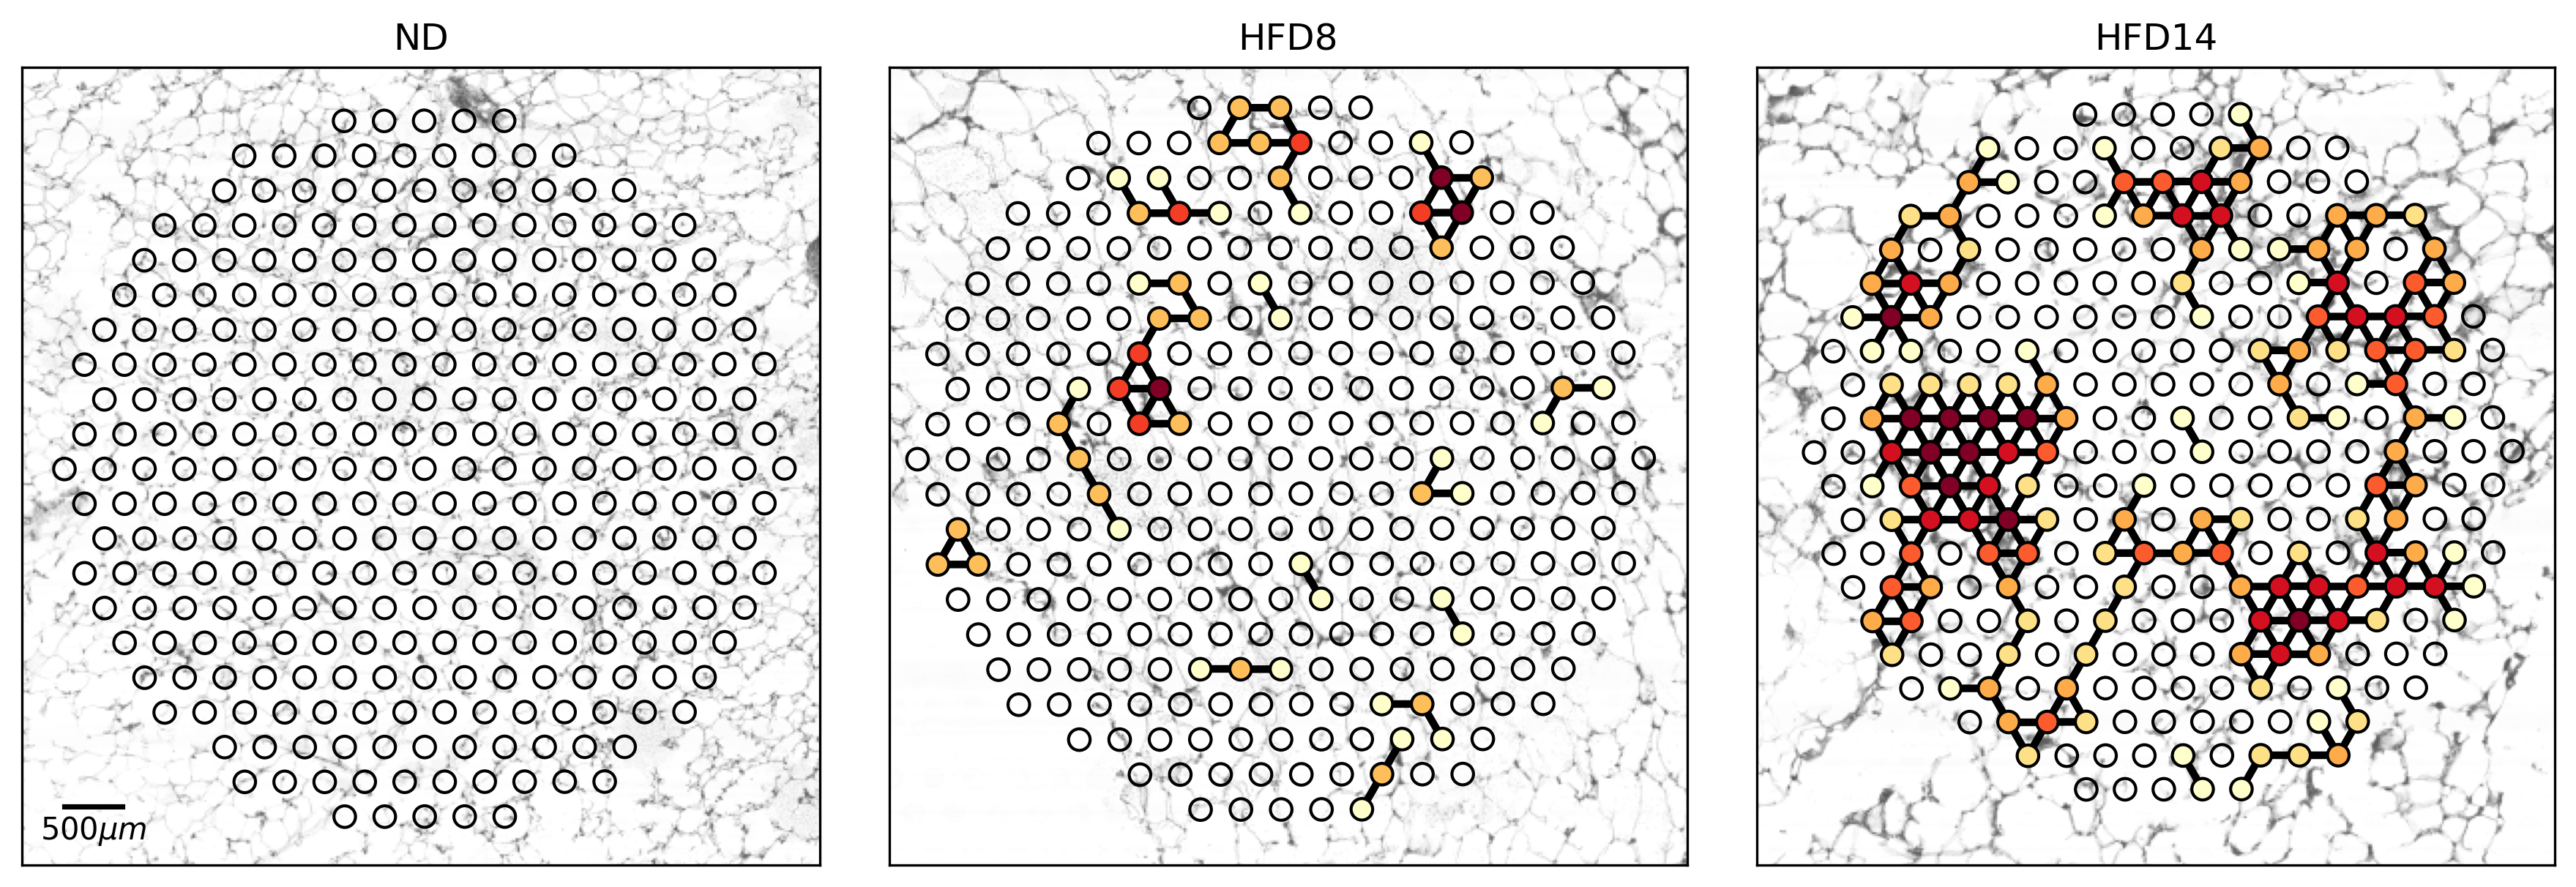

In [26]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 4

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

plotBox = 400
cmap = 'YlOrRd'

centralities = []

for i, key in enumerate(keys):
    
    G = pway[key]
    cf = getCentralities(G)
    cf['key'] = key
    
    centralities.append(cf)
    
    mask = (cf['degree_centrality'] > 0)
    connectedNodes = cf[mask]['spotId'].to_list()
    disconnectedNodes = cf[~mask]['spotId'].to_list()
    
    colors = cf[mask]['degree_centrality'].to_list()
    
#     nx.draw_networkx_nodes(G,
#                pos=G.pos,
#                node_size=50,
#                node_color='None',
#                # alpha=0.4,
#                edgecolors='k',
#                linewidths=1,
#                ax=axs[i])
    
    nx.draw_networkx_nodes(G,
                   pos=G.pos,
                   node_size=50,
                   node_color=colors,
                   # alpha=0.4,
                   nodelist=connectedNodes,
                   cmap='YlOrRd',
                   edgecolors='k',
                   linewidths=1,
                   ax=axs[i])
    
    nx.draw_networkx_nodes(G,
                       pos=G.pos,
                       node_size=50,
                       node_color='None',
                       # alpha=0.5,
                       nodelist=disconnectedNodes,
                       edgecolors='k',
                       linewidths=1,
                       ax=axs[i])
    
    nx.draw_networkx_edges(G,
                           pos=G.pos,
                           width=2.5,
                           edge_color='k',
                           ax=axs[i])     
    
    axs[i].set_title(key)
    axs[i].set_aspect('equal')
    axs[i].invert_yaxis()
    
    img = lowres[key]
    
    axs[i].imshow(img, 
                  cmap='binary_r', 
                  alpha=0.7,
                  zorder=0)
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    
    # get the center node index
    xMid = kdf['x'].mean()
    yMid = kdf['y'].mean()
    
    xLb = int(xMid - (plotBox / 2))
    xUb = int(xMid + (plotBox / 2))
    
    yLb = int(yMid - (plotBox / 2))
    yUb = int(yMid + (plotBox / 2))

    axs[i].set_ylim([yUb, yLb])
    axs[i].set_xlim([xLb, xUb])    
    axs[i].set_title(key)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
    if i == 0:
        label = 500
        units = getscalebar(key, label)
    
        scalebar = AnchoredSizeBar(axs[i].transData,
                                   units, 
                                   f'{label}' + r'$\mu m$', 
                                   'lower left', 
                                   pad=0.5,
                                   color='k',
                                   frameon=False,
                                   size_vertical=1,
                                   fontproperties={'size':10})
        
        axs[i].add_artist(scalebar)
    

plt.tight_layout()
centralities = pd.concat(centralities, ignore_index=True)
centralities.head()

In [27]:
# makeColorbar("RdYlGn", 0.3, 1, '', 'vertical', ["Decrease", "Increase"])

In [28]:

# # # insuling resistence pathway
# query = ['INS2', 'INS1', 'RPS6KA3', 'RPS6KA1', 'RPS6KA2', 'RPS6KA6', 'PPP1CA', 'PPP1CB', 'PPP1CC', 'PPP1CCB', 'PPP1R3A', 'PPP1R3C', 'PPP1R3B', 'PPP1R3D', 'PPP1R3E', 'INSR', 'IRS1', 'PTPN1', 'PTPN11', 'PTPRF', 'PIK3CA', 'PIK3CD', 'PIK3CB', 'PIK3R2', 'PIK3R1', 'PIK3R3', 'AKT1', 'AKT2', 'AKT3', 'MTOR', 'RPS6KB2', 'RPS6KB1', 'PRKCB', 'IL6', 'STAT3', 'SOCS3', 'GSK3B', 'GYS1', 'GYS2', 'TNF', 'TNFRSF1A', 'MAPK8', 'MAPK9', 'MAPK10', 'IKBKB', 'NFKBIA', 'NFKB1', 'RELA', 'NOS3', 'PRKCZ', 'TBC1D4', 'SLC2A4', 'PRKAA1', 'PRKAA2', 'PRKAB1', 'PRKAB2', 'PRKAG1', 'PRKAG3', 'PRKAG2', 'ACACB', 'CPT1B', 'AGT', 'SLC27A1', 'SLC27A4', 'SLC27A2', 'SLC27A3', 'SLC27A5', 'SLC27A6', 'CD36', 'PRKCQ', 'PRKCD', 'PTPA', 'SREBF1', 'IRS2', 'TRIB3', 'PYGM', 'PYGB', 'PYGL', 'FOXO1', 'PCK1', 'PCK2', 'G6PC', 'G6PC2', 'G6PC3', 'SLC2A2', 'NR1H3', 'NR1H2', 'PPARGC1B', 'MLX', 'MLXIP', 'MLXIPL', 'CPT1A', 'PRKCE', 'PPARGC1A', 'PPARA', 'PDPK1', 'PTEN', 'OGA', 'OGT', 'SLC2A1', 'GFPT1', 'GFPT2', 'CRTC2', 'CREB1', 'CREB3', 'CREB3L1', 'CREB3L2', 'CREB3L3', 'CREB3L4', 'CREB5']
# query = ['LGALS3', 'PLIN2']


k = 10
res = []

for i, key in enumerate(keys):
    
    # get nieghborhoods
    kdf = df[df['key'] == key].reset_index(drop=True)
    knnInd = getKnn(kdf, 6)
    
    transId = knnInd2Id(kdf, knnInd)
    
    # get spatial data
    sdf = spt[key]
    cols = sdf.columns.to_list()
    
#     cols = []
    
#     # we only consider genes with some expression 
#     for x in query:
#         if x in sdf.columns:
#             if sdf[x].sum() > 3:
#                 cols.append(x)
            

#     sdf = sdf[cols]
    bdf = blur(sdf, transId)
    
    G = pway[key]
    cf = getCentralities(G)
    
    measures = cf.columns.to_list()[1:]
    
    cf['key'] = key
    
    cf = pd.merge(cf, bdf, 
                  how='left', 
                  left_on='spotId', 
                  right_index=True)
    
    for gene in cols:

        for measure in measures:
            r, pval = scipy.stats.pearsonr(cf[measure], cf[gene])    
            
            row = {
                'key' : key,
                'measure' : measure,
                'gene' : gene,
                'correlation' : r,
                'pval' : pval
            }
            
            res.append(row)
    
res = pd.DataFrame(res)
res.head()

/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


key                 measure  gene  correlation  pval
0  ND       degree_centrality  XKR4          NaN   NaN
1  ND  betweenness_centrality  XKR4          NaN   NaN
2  ND    closeness_centrality  XKR4          NaN   NaN
3  ND     harmonic_centrality  XKR4          NaN   NaN
4  ND  eigenvector_centrality  XKR4          NaN   NaN

In [54]:
top = 30
alpha = 0.001
measure = "eigenvector_centrality"

mask = (res['pval'] < alpha) & (res['measure'] == measure)
sig = res[mask]

sig = pd.pivot_table(sig, 
                     values='correlation', 
                     index=['gene'],
                     columns=['key'])

sig = sig.reset_index(drop=False)
sig = sig.fillna(0)

sig = sig.sort_values(by='HFD14', ascending=False)
sig['geneName'] = sig['gene'].apply(lambda x: str(x).lower().capitalize())



# earlyMask =  (sig['HFD14'] > 0.3) & (sig['HFD8'] > 0.2)
# sig = sig[earlyMask]
# print(f"{sig.shape=}")


# # # for GSR
# genes = sig['gene'].to_list()

sig.head(20)


# pdf = pd.melt(sig.head(top), id_vars=['gene', 'geneName'])


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 7, 2

# sns.scatterplot(data=pdf, 
#                 x='geneName', 
#                 y='value',
#                 hue='key',
#                 ec='k',
#                 s=45,
#                 zorder=3,)

# plt.grid(zorder=0)
# plt.ylabel(f"Correlation")
# plt.xlabel(f"")
# plt.xticks(rotation=90)
# ax = plt.gca()

# plt.legend(bbox_to_anchor=(1, 1.05))

# sig.head(top)

key            gene     HFD14  HFD8       geneName
758           NOL12  0.775259   0.0          Nol12
763             NPY  0.769682   0.0            Npy
92         ARHGEF28  0.764210   0.0       Arhgef28
17    A530013C23RIK  0.764210   0.0  A530013c23rik
318           DUS3L  0.753498   0.0          Dus3l
602            LIG1  0.753231   0.0           Lig1
1015           SHC2  0.734855   0.0           Shc2
299           DIMT1  0.728637   0.0          Dimt1
209            CHD8  0.716436   0.0           Chd8
797          PAPSS1  0.706603   0.0         Papss1
1192           TTC5  0.703608   0.0           Ttc5
166         CCDC117  0.699631   0.0        Ccdc117
1104         TAMM41  0.699631   0.0         Tamm41
1238         VPS37B  0.699631   0.0         Vps37b
1291          ZFP62  0.699631   0.0          Zfp62
778            OFD1  0.699631   0.0           Ofd1
626           MAIP1  0.699631   0.0          Maip1
136           BLCAP  0.699631   0.0          Blcap
724           NAA40  0.699631   0.0          Naa40
1068         SPATA7  0.699631   0.0         Spata7

In [30]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [47]:
db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

nQ = 500
enrich = gget.enrichr(genes[:nQ], database=db)
enrich = enrich[enrich['p_val'] < alpha]


enrich = enrich[['path_name', 'overlapping_genes']]
print(enrich[['path_name','overlapping_genes']].head(10))


mlb = MultiLabelBinarizer()
enrich = enrich.join(pd.DataFrame(mlb.fit_transform(enrich.pop('overlapping_genes')),
                          columns=mlb.classes_,
                          index=enrich.index))

enrich = enrich.set_index('path_name')


# scale each gene by it's correlation
for g in enrich.columns:
    cor = sig.loc[sig['gene'] == g]['HFD14'].values[0]
    enrich[g] = enrich[g] * cor
    
enrich.columns = [x.lower().capitalize() for x in enrich.columns]

# drop columns not in any
colInd = np.where(enrich.head(15).sum(axis=0) > 0)
enrich = enrich[enrich.columns[colInd]]
    
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 15,4

# sns.heatmap(data=enrich.head(15), 
#             cbar=False,
#             lw=1,
#             linecolor='grey',
#             cmap='Blues')

# plt.ylabel("")
# plt.xlabel("")




Tue Feb 14 09:02:43 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


                                           path_name  \
0  negative regulation of phosphatidylinositol 3-...   
1           regulation of TOR signaling (GO:0032006)   
2           glutamine metabolic process (GO:0006541)   
3               regulation of autophagy (GO:0010506)   
4  regulation of establishment of protein localiz...   
5            osteoclast differentiation (GO:0030316)   
6              regulation of chemotaxis (GO:0050920)   
7  glutamine family amino acid metabolic process ...   
8  negative regulation of cell population prolife...   
9  negative regulation of TOR signaling (GO:0032007)   

               overlapping_genes  
0                  [TSC2, TREM2]  
1          [TSC2, SH3BP4, TREM2]  
2                    [NIT2, GLS]  
3  [GOLGA2, PSAP, SH3BP4, TREM2]  
4                  [TREM2, CTSD]  
5                [GPR183, TREM2]  
6                [GPR183, TREM2]  
7                    [NIT2, GLS]  
8  [TSC2, SH3BP4, TREM2, ADRA1A]  
9                 [TSC2, SH3BP4] 

In [ ]:
# makeColorbar("Blues", 0.3, 2, 'Correlation', 'vertical', ["Low", "High"])

In [ ]:
# break

# Ligand Receptor Analysis

In [ ]:
keys = ['ND', 'HFD8', 'HFD14']

lrData = {}

for key in keys:
    sdf = spt[key]
    newCols = {}
    
    for idx, row in lr.iterrows():
        l = row['ligand']
        r = row['receptor']
        
        if l in sdf.columns and r in sdf.columns:
            gMean = scipy.stats.gmean(sdf[[l, r]], axis=1)
            lrName = row['Pair.Name']
            newCols[lrName] = gMean
    
    lrdf = pd.DataFrame(newCols)
    lrdf.index = sdf.index
    
    # remove zero-sum columns 
    lrdf = lrdf.loc[:, (lrdf.sum(axis=0) != 0)]
    print(sdf.shape, lrdf.shape)
    
    lrData[key] = lrdf


print('done')

In [ ]:
res = []
keys = ['ND', 'HFD8', 'HFD14']

for i, key in enumerate(keys):
    
    lf = lrData[key]
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    kind = getKnn(kdf, k=6, metric='minkowski')
    transId = knnInd2Id(kdf, kind)
    lf = blur(lf, transId)
    
    lrPairs = lf.columns.to_list()
    
    nodes = centralities[centralities['key'] == key]
    mask = (nodes['degree_centrality'] > 0)
    
    connected = nodes[mask]['spotId'].to_list()
    disconnected = nodes[~mask]['spotId'].to_list()
    
    # only perform tests if there is something to test!
    if len(connected) > 0:
        
        mask = lf.index.isin(connected)
        inNet = lf[lf.index.isin(connected)]
        outNet = lf[~lf.index.isin(connected) &  lf.index.isin(nodes['spotId'])]
        
        for lrp in lrPairs:
            score, pval = scipy.stats.ranksums(inNet[lrp], 
                                               outNet[lrp],
                                               alternative='two-sided')
            
            lfc = np.log2(inNet[lrp].mean()+1) - np.log2(outNet[lrp].mean()+1)
                   
            row = {
                'key' : key,
                'lr' : lrp,
                'score' : score,
                'pval' : pval,
                'log2foldchange' : lfc, 
                'meanNiche' : inNet[lrp].mean(),
                'meanNieghbor' : outNet[lrp].mean(),
            }
            res.append(row)
            
res = pd.DataFrame(res)
res.head()

In [ ]:
res.shape

In [ ]:
top = 40
alpha = 0.05
pdf = res.copy()

# pdf = pd.concat([pdf.head(top), pdf.tail(top)])
pdf['isSig'] = pdf['pval'].apply(lambda x: "*" if x < alpha else "")
pdf['geneSig'] = pdf['lr'] + pdf['isSig']


pdf = pd.pivot_table(pdf, index=['geneSig'], values='log2foldchange', columns='key')
pdf = pdf.reset_index(drop=False)
pdf = pdf.fillna(0)
pdf = pdf.sort_values(by='HFD14', ascending=False)

pdf = pdf.head(top)
pdf = pd.melt(pdf, id_vars=['geneSig'])


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3, 8

sns.scatterplot(data=pdf,
                y='geneSig', 
                x='value', 
                hue='key',
                ec='k', 
                zorder=2)

plt.legend(loc='lower right')
plt.ylabel("")
plt.xlabel("Fold Change (log2)")
plt.grid(zorder=0)
# plt.xlim([0, 0.5])


In [ ]:
# # lft = 0.2
# # mask = (res['log2foldchange'] < -lft) | (res['log2foldchange'] > lft)
# sig = res[mask].sort_values(by='log2foldchange')
# print(f"{sig.shape=}")
# sig

In [ ]:
def gauss2d(mu, sigma, size):
    x = np.random.normal(mu, sigma, size)
    y = np.random.normal(mu, sigma, size)
    return (x, y)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 7, 4


key = "HFD14"
cmap = 'Blues'

# Psap-Lrp1
# Col1a1-Cd36
# C3-Cd81
#Apoe-Lrp1

ligand = "Apoe"
ligand = f"{ligand.upper()}"

receptor = "Lrp1"
receptor = f"{receptor.upper()}"

G = pway[key]
mf = meta[key]
sdf = spt[key]
cf = getCentralities(G)

mf = pd.merge(mf, cf, 
              how='left', 
              left_on='spotId',
              right_on='spotId')


kdf = df[df['key'] == key].reset_index(drop=True)

""" Blur the spatial data"""
kind = getKnn(kdf, k=6, metric='minkowski')
transId = knnInd2Id(kdf, kind)
sdf = blur(sdf[[ligand, receptor]], transId)


""" get the niche neighbors """
mask = (mf['degree_centrality'] > 0)
connectedNodes = mf[mask]['spotId'].to_list()
disconnectedNodes = mf[~mask]['spotId'].to_list()

mask = (mf['degree_centrality'] > 0 ) & (mf['degree_centrality'] < mf['degree_centrality'].max()) 
edgeNodes = mf[mask]['spotId'].to_list()
interriorNodes = [x for x in connectedNodes if not x in edgeNodes]

otherEdgeNodes = []

for n in edgeNodes:
    nbrs = mf[mf['spotId'].isin(transId[n])]
    nbrs = nbrs[nbrs['degree_centrality'] == 0]['spotId'].to_list()
    otherEdgeNodes += nbrs
    
    
    
connectedL = []
connectedR = []

for n in connectedNodes:
    l = sdf.loc[n][ligand]
    connectedL.append(l)
    
    r = sdf.loc[n][receptor]
    connectedR.append(r)

nbrL = []
nbrR = []
for n in otherEdgeNodes:
    l = sdf.loc[n][ligand]
    nbrL.append(l)
    
    r = sdf.loc[n][receptor]
    nbrR.append(r)
    
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()


""" PLOT THE LIGAND """
nx.draw_networkx_nodes(G,
               pos=G.pos,
               node_size=60,
               node_color=connectedL,
               cmap=cmap,
               nodelist=connectedNodes,
               edgecolors='r',
               linewidths=1.5, 
               ax=axs[0])

nx.draw_networkx_nodes(G,
               pos=G.pos,
               node_size=60,
               node_color=nbrL,
               cmap=cmap,
               nodelist=otherEdgeNodes,
               edgecolors='gold',
               linewidths=1.5,
               ax=axs[0])

nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=2,
                       edge_color='k',
                       ax=axs[0]) 

""" PLOT THE RECEPTOR"""
nx.draw_networkx_nodes(G,
               pos=G.pos,
               node_size=60,
               node_color=connectedR,
               cmap=cmap,
               nodelist=connectedNodes,
               edgecolors='r',
               linewidths=1.5, 
               ax=axs[1])

nx.draw_networkx_nodes(G,
               pos=G.pos,
               node_size=60,
               node_color=nbrR,
               cmap=cmap,
               nodelist=otherEdgeNodes,
               edgecolors='gold',
               linewidths=1.5,
               ax=axs[1])

nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=2,
                       edge_color='k',
                       ax=axs[1])   

axs[0].set_title(f'Ligand: {ligand.lower().capitalize()}')
axs[0].set_aspect('equal')
axs[0].invert_yaxis()

axs[1].set_title(f'Receptor: {receptor.lower().capitalize()}')
axs[1].set_aspect('equal')
axs[1].invert_yaxis()

plt.tight_layout()

In [ ]:
plt.rcParams['figure.dpi'] = 300
makeColorbar("RdYlGn", 0.3, 2.5, '14w Multicorrelation', 'vertical', ["Low", "High"])

In [ ]:
# break

# Sampling networks

In [ ]:
# sampling networks 

keys = ['ND', 'HFD8', 'HFD14']

networkSize = 50
nNetworks = 500
edgeThreshold = 0.45 # harmonic mean threshold 
edgeRadius = 25 # distance between spots
sampleSigma = 0.1 # variance around the center of the image

graph = {}
meta = {}
deets = {}

keyInds = np.random.choice(list(range(len(keys))), nNetworks, replace=True)

for i, ki in enumerate(keyInds):
    key = keys[ki]
    kdf = df[df['key'] == key].reset_index(drop=True)
    
    sample = kdf.sample(1)
    sx = sample['x'].values[0]
    sy = sample['y'].values[0]
    
    # generate the graph 
    G, mf = getGraph(kdf, sx, sy, networkSize)

    # define the node properties
    mf['norm'] = mf['Mac5'] / mf['Mac5'].max()

    node_attr = mf.set_index('spotId').to_dict('index')
    nx.set_node_attributes(G, node_attr)    

    # define connections
    edgelist = []
    for u,v,e in G.edges(data=True):
        if e['weight'] < edgeRadius:

            x1 = G.nodes[u]['norm']
            x2 = G.nodes[v]['norm']

            hmean = scipy.stats.hmean([x1, x2])

            if hmean > edgeThreshold:
                edgelist.append((u, v, hmean))

    # build the new graph based on connections
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    H.add_weighted_edges_from(edgelist)
    H.pos = G.pos 

    # add centralities
    cf = getCentralities(H)

    node_attr = cf.set_index('spotId').to_dict('index')
    nx.set_node_attributes(H, node_attr)    

    mf = pd.merge(mf, cf, 
                  left_on='spotId', 
                  right_on='spotId', 
                  how='left')

    graph[i] = H
    meta[i] = mf
    deets[i] = {
        'key' : key,
        'x' : sx,
        'y' : sy,
    }

print('done')

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 9, 9

plotBox = 300

fig, axs = plt.subplots(3, 3)
axs = axs.ravel()

plotI = 0


details = pd.DataFrame.from_dict(deets, orient='index')

sampleList = []

for key in keys:
    tosample = details[details['key'] == key].sample(3)
    sampleList += tosample.index.to_list()
    

for i in sampleList:
    key = deets[i]['key']
    G = graph[i]
    mf = meta[i]
    
    node_color = mf['degree_centrality'].to_list()
    
    nx.draw(G, G.pos,
            with_labels=False,
            ax=axs[plotI], 
            node_color=node_color,
            edge_color="k",
            edgecolors='k',
            linewidths=1,
            width=2,
            cmap="Reds",
            node_size=50)
    
    axs[plotI].set_title(key)
    
    
    img = lowres[key]
    axs[plotI].imshow(img, 
                  cmap='binary_r', 
                  zorder=0)
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    
    # get the center node index
    xMid = deets[i]['x']
    yMid = deets[i]['y']
    
    xLb = int(xMid - (plotBox / 2))
    xUb = int(xMid + (plotBox / 2))
    
    yLb = int(yMid - (plotBox / 2))
    yUb = int(yMid + (plotBox / 2))

    axs[plotI].set_ylim([yUb, yLb])
    axs[plotI].set_xlim([xLb, xUb])    
    axs[plotI].set_title(key)
    axs[plotI].set_xticks([])
    axs[plotI].set_yticks([])    
    plotI += 1

In [ ]:
# break

In [ ]:
"""Plot the sample space
"""



# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 9, 9

# keyQ = "HFD8"

# for i in range(nNetworks):
#     key = deets[i]['key']
    
#     if key == keyQ:
#         G = graph[i]
#         mf = meta[i]
        
#         x = deets[i]['x']
#         y = deets[i]['y']
        
#         plt.scatter(x, y,
#                     s=networkSize*5,
#                     c="r",
#                     alpha=0.1,)
        
#         plt.scatter(x, y,
#                     s=5,
#                     c="r",)
    
# img = lowres[keyQ]
# plt.imshow(img, 
#            cmap='binary_r', 
#            zorder=0)

# _ = plt.xticks([])
# _ = plt.yticks([])

In [ ]:
# break

In [ ]:
res = []

for i in range(nNetworks):
    key = deets[i]['key']
    G = graph[i]
    
    row = {
        'Diet Condition' : key,
        'nEdges' : len(G.edges())
    }
    
    res.append(row)
    
    
res = pd.DataFrame(res)
res = res.sort_values(by='Diet Condition', ascending=False)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 3
sns.histplot(data=res,
             x='nEdges',
             hue='Diet Condition',
             bins=20)

plt.xlabel("Number of Edges")
plt.ylabel("Number of Networks")

In [ ]:
res = []

for i in range(nNetworks):
    G = graph[i]
    
    # largest connected component
    components = sorted(nx.connected_components(G), key=len, reverse=True)
    cc = G.subgraph(components[0])
    
    nCC = len(cc.nodes())
    
    # if nCC < 4:
    #     sigma = 0
    # else:
    #     sigma = nx.sigma(cc)

    row = {
        'graphIdx' : i, 
        'key' : deets[i]['key'],
        'density' : nx.density(G),
        'node_connectivity' :  nx.node_connectivity(G),
        'average_clustering' : nx.average_clustering(G),
        'degree_assortativity_coefficient' : nx.degree_assortativity_coefficient(G),
        'algebraic_connectivity' : nx.algebraic_connectivity(G),
        # 'small-world' : sigma
    }
    
    res.append(row)

    
res = pd.DataFrame(res)

res = res.sort_values(by='key', ascending=False)
res.head()

g = sns.kdeplot(data=res,
             x='average_clustering',
             # shade=True,
             hue='key')

g.legend_.set_title(None)

plt.xlabel("Mean Clustering Coefficient")
# plt.ylabel("Number of Networks")

plt.legend()

In [ ]:
res = []

for i in range(nNetworks):
    key = deets[i]['key']
    G = graph[i]
    mf = meta[i]
    
    ldf = lrData[key]
    
    mf = mf[mf['degree_centrality'] > 0].reset_index(drop=True)
    mf['network'] = i
    mf = pd.merge(mf, ldf, 
                  how='left',
                  left_on='spotId', 
                  right_index=True)
    
    res.append(mf)
    
    # break

    
    
res = pd.concat(res, ignore_index=True)
res = res.drop_duplicates(subset=['key', 'spotId'])

res = res.sort_values(by='key', ascending=False)
print(res.head())

In [ ]:
# col = 'Apoe-Lrp1'
# pdf = res.fillna(0)
# pdf[col] = np.log(pdf[col])

# g = sns.histplot(data=pdf,
#                  x=col,
#                  hue='key',
#                  bins=20)

# g.legend_.set_title(None)
# plt.xlabel(f"{col} Expression (log)")
# plt.ylabel("Spots in Mac5 Niche")
# # plt.yscale('log')

In [ ]:

# def center_crop(img, new_width=None, new_height=None):        

#     width = img.shape[1]
#     height = img.shape[0]

#     if new_width is None:
#         new_width = min(width, height)

#     if new_height is None:
#         new_height = min(width, height)

#     left = int(np.ceil((width - new_width) / 2))
#     right = width - int(np.floor((width - new_width) / 2))

#     top = int(np.ceil((height - new_height) / 2))
#     bottom = height - int(np.floor((height - new_height) / 2))

#     if len(img.shape) == 2:
#         center_cropped_img = img[top:bottom, left:right]
#     else:
#         center_cropped_img = img[top:bottom, left:right, ...]

#     return center_cropped_img


# def get_crop(img, new_width=None, new_height=None):        

#     width = img.shape[1]
#     height = img.shape[0]

#     if new_width is None:
#         new_width = min(width, height)

#     if new_height is None:
#         new_height = min(width, height)

#     left = int(np.ceil((width - new_width) / 2))
#     right = width - int(np.floor((width - new_width) / 2))

#     top = int(np.ceil((height - new_height) / 2))
#     bottom = height - int(np.floor((height - new_height) / 2))
    
#     return left, right, bottom, top

In [ ]:
# connectivties = {
#     'ND' :    {"connected" : [], "disconnected" : []},
#     'HFD8' :  {"connected" : [], "disconnected" : []},
#     'HFD14' : {"connected" : [], "disconnected" : []},
# }

# # aggregate networks
# for i in range(nNetworks):
#     key = deets[i]['key']
#     G = graph[i]
#     mf = meta[i]
    
#     mask = (mf['degree_centrality'] > 0) 
#     connectivties[key]['connected'] += mf[mask]['spotId'].to_list()
#     connectivties[key]['disconnected'] += mf[~mask]['spotId'].to_list()
    
    
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 5, 5
    
# shrink = 0.5
# key = 'HFD8'

# conDict = connectivties[key]


# connected = list(set(conDict['connected']))
# disconnected = list(set(conDict['disconnected']))

# # if it's connected in another network, consider it connected
# disconnected = [x for x in disconnected if not x in connected]


# kdf = df[df['key'] == key].reset_index(drop=True)

# # plot the connected components
# mask = kdf['spotId'].isin(connected)
# plt.scatter(kdf['x'][mask],
#             kdf['y'][mask],
#             c='r',
#             alpha=0.4,
#             s=7)


# mask = kdf['spotId'].isin(disconnected)
# plt.scatter(kdf['x'][mask],
#             kdf['y'][mask],
#             c='b',
#             alpha=0.4,
#             s=7)
    
    
# img = lowres[key]

# # crop image to center
# m, n = img.shape
# l, r, b, t = get_crop(img, int(m*shrink), int(n*shrink))

# img = skimage.filters.unsharp_mask(img, 
#                                    amount=2, 
#                                    radius=10)

# plt.imshow(img, 
#            cmap='binary_r', 
#            zorder=0)

# plt.ylim([b, t])
# plt.xlim([l, r])
# plt.yticks([])
# plt.yticks([])
# plt.xticks([])
# plt.title(key)

# Differential LR Analysis

In [ ]:
res = []

connectivties = {
    'ND' :    {"connected" : [], "disconnected" : []},
    'HFD8' :  {"connected" : [], "disconnected" : []},
    'HFD14' : {"connected" : [], "disconnected" : []},
}

# aggregate networks
for i in range(nNetworks):
    key = deets[i]['key']
    G = graph[i]
    mf = meta[i]
    
    mask = (mf['degree_centrality'] > 0) 
    connectivties[key]['connected'] += mf[mask]['spotId'].to_list()
    connectivties[key]['disconnected'] += mf[~mask]['spotId'].to_list()
    
    
for key, conDict in connectivties.items():
    connected = list(set(conDict['connected']))
    disconnected = list(set(conDict['disconnected']))
    
    # if it's connected in another network, consider it connected
    disconnected = [x for x in disconnected if not x in connected]
    
    print(f"{key} {len(connected)=} {len(disconnected)=}")
    
    lf = lrData[key]    
    lrPairs = lf.columns.to_list()

    mask = lf.index.isin(connected)
    inNet = lf[lf.index.isin(connected)]
    outNet = lf[lf.index.isin(disconnected)]

    for lrp in lrPairs:
        score, pval = scipy.stats.ranksums(inNet[lrp], 
                                           outNet[lrp],
                                           alternative='two-sided')

        lfc = np.log2(inNet[lrp].mean()+1) - np.log2(outNet[lrp].mean()+1)

        row = {
            'key' : key,
            'lr' : lrp,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc, 
            'nConnected' : len(connected),
            'nDisonnected' : len(disconnected),
        }
        res.append(row)
            
        # break

res = pd.DataFrame(res)
res.head()

In [ ]:
lrQuery = [
    'Apoe-Lrp1'
]

pdf = res[res['lr'].isin(lrQuery)]

pdf.head()

In [ ]:
alpha = 0.001

sig = res[res['pval'] < alpha]
sig

In [ ]:
top = 6

grpd = res.groupby(['lr', 'key']).agg(
    meanFold = ('log2foldchange', 'mean'),
    medianFold = ('log2foldchange', np.median),
).reset_index()

grpd = grpd.sort_values(by='meanFold', ascending=False)

grpd = pd.concat([grpd.head(top), grpd.tail(top)], ignore_index=True)

print(f"{grpd.shape=}")
grpd

In [ ]:
""" now check for LR pairs between Mac5 Neighborhoods and neighbooring cells """

lrBlurred = {}

b = 18

keys = ['ND', 'HFD8', 'HFD14']

# blur the LR pairs
for key in keys:
    
    kdf = df[df['key'] == key].reset_index(drop=True)
    knnInd = getKnn(kdf, b)
    transId = knnInd2Id(kdf, knnInd)

    # subset the spatial by just LR genes
    ligands = list(lr['ligand'].unique())
    receptors = list(lr['receptor'].unique())
    
    lrGenes = list(set(ligands + receptors))
    lrGenes = [x for x in lrGenes if x in sdf.columns]
    
    sdf = spt[key]
    sdf = sdf[lrGenes]
    
    # blur all LR genes
    bdf = blur(sdf, transId)
    print(key, bdf.shape)
    lrBlurred[key] = bdf
    
print('done')    

In [ ]:
k = 6

connectivties = {
    'ND' :    {"nicheNodes" : [], "neighbors" : []},
    'HFD8' :  {"nicheNodes" : [], "neighbors" : []},
    'HFD14' : {"nicheNodes" : [], "neighbors" : []},
}

# aggregate networks
for i in range(nNetworks):
    key = deets[i]['key']
    G = graph[i]
    mf = meta[i]
    lf = lrBlurred[key]
    
    # get connected nodes
    knnInd = getKnn(mf, k)
    transId = knnInd2Id(mf, knnInd)
    
    # not unconnected and not-fully conmected
    mask = (mf['degree_centrality'] > 0) & (mf['degree_centrality'] < mf['degree_centrality'].max())

    connected = mf[mask] # DON'T RESET INDEX!
    
    for idx, row in connected.iterrows():
        spotId = row['spotId']
        connectivties[key]['nicheNodes'].append(spotId)
        
        # search the neighbors
        nbrs = mf[mf['spotId'].isin(transId[spotId])]
        nbrs = nbrs[nbrs['degree_centrality'] == 0]['spotId'].to_list()
        
        connectivties[key]['neighbors'] += nbrs

    
print('done')

In [ ]:
res = []

for key, conDict in connectivties.items():
    nicheNodes = list(set(conDict['nicheNodes']))
    neighbors = list(set(conDict['neighbors']))
    
    # if it's connected in another network, consider it connected
    neighbors = [x for x in neighbors if not x in nicheNodes]
    
    print(f"{key} {len(nicheNodes)=} {len(neighbors)=}")
    
    
    lf = lrData[key]    
    lrPairs = lf.columns.to_list()

    mask = lf.index.isin(nicheNodes)
    inNet = lf[lf.index.isin(nicheNodes)]
    outNet = lf[lf.index.isin(neighbors)]

    for lrp in lrPairs:
        score, pval = scipy.stats.ranksums(inNet[lrp], 
                                           outNet[lrp],
                                           alternative='two-sided')

        lfc = np.log2(inNet[lrp].mean()+1) - np.log2(outNet[lrp].mean()+1)

        row = {
            'key' : key,
            'lr' : lrp,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc, 
            'nNicheNodes' : len(nicheNodes),
            'nNeighbors' : len(neighbors),
        }
        res.append(row)
            
        # break

res = pd.DataFrame(res)
# res.head()

alpha = 0.001

sig = res[res['pval'] < alpha]
sig

In [ ]:
# break

# Differential Gene Analysis

In [ ]:
res = []

connectivties = {
    'ND' :    {"connected" : [], "disconnected" : []},
    'HFD8' :  {"connected" : [], "disconnected" : []},
    'HFD14' : {"connected" : [], "disconnected" : []},
}

# aggregate networks
for i in range(nNetworks):
    key = deets[i]['key']
    G = graph[i]
    mf = meta[i]
    
    mask = (mf['degree_centrality'] > 0) 
    connectivties[key]['connected'] += mf[mask]['spotId'].to_list()
    connectivties[key]['disconnected'] += mf[~mask]['spotId'].to_list()
    
    
for key, conDict in connectivties.items():
    connected = list(set(conDict['connected']))
    disconnected = list(set(conDict['disconnected']))
    
    # if it's connected in another network, consider it connected
    disconnected = [x for x in disconnected if not x in connected]
    
    print(f"{key} {len(connected)=} {len(disconnected)=}")
    
    sf = spt[key]
    genes = sf.columns.to_list()

    mask = sf.index.isin(connected)
    inNet = sf[sf.index.isin(connected)]
    outNet = sf[sf.index.isin(disconnected)]

    for gene in genes:
        score, pval = scipy.stats.ranksums(inNet[gene], 
                                           outNet[gene],
                                           alternative='two-sided')

        lfc = np.log2(inNet[gene].mean()+1) - np.log2(outNet[gene].mean()+1)

        row = {
            'key' : key,
            'gene' : gene,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc, 
            'nConnected' : len(connected),
            'nDisonnected' : len(disconnected),
        }
        res.append(row)
            
        # break

res = pd.DataFrame(res)
res.head()

In [ ]:
# get differences between LFC in HFD8 and HFD14
top = 35
nQuery = 100

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6.5, 3

pdf = pd.pivot_table(res, 
                     values='log2foldchange', 
                     index='gene', 
                     columns='key')

pdf = pdf.reset_index(drop=False)
pdf['diff'] = pdf['HFD14'] - pdf['HFD8']
pdf = pdf.sort_values(by='diff', ascending=False)
pdf['geneName'] = pdf['gene'].apply(lambda x: str(x).lower().capitalize())

sns.scatterplot(data=pdf.head(top), 
                y='diff',
                x='geneName', 
                edgecolor="k", 
                zorder=3)

plt.grid(True, zorder=0)
plt.xticks(rotation=90)

plt.xlabel("")
plt.ylabel("Delta Fold Change (log2)")


genes = pdf['gene'].head(nQuery).to_list()
print(genes)

db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
# db = 'ontology'
enrich = gget.enrichr(genes, database=db)
enrich = enrich[enrich['p_val'] < alpha]
enrich.head(10)


In [ ]:
break

In [ ]:
# query = [
#     'LGALS3',
#     'CTSB',
#     'PSAP',
#     'FTL1',
#     'GPNMB',
#     'MMP12',
#     'CD36',
# ]

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 9, 3

# fig, axs = plt.subplots(1, 3, sharey=True)
# axs = axs.ravel()

# keys = ['ND', 'HFD8', 'HFD14']

# for i, key in enumerate(keys):
    
#     sdf = spt[key]
#     sdf = sdf[query]
#     conDict = connectivties[key]
    
#     connected = list(set(conDict['connected']))
#     disconnected = list(set(conDict['disconnected']))
    
#     # if it's connected in another network, consider it connected
#     disconnected = [x for x in disconnected if not x in connected]
    
    
#     con = sdf[sdf.index.isin(connected)].reset_index(drop=False)
#     con['type'] = 'Connected'
#     discon = sdf[sdf.index.isin(disconnected)].reset_index(drop=False)
#     discon['type'] = 'Disconnected'
    
#     pdf = pd.concat([con, discon], ignore_index=True)
    
#     for g in query:
#         pdf[g] = np.sqrt(pdf[g] / pdf[g].max())
    
#     pdf = pd.melt(pdf, id_vars=['index', 'type'], value_vars=query)
#     pdf['gene'] = pdf['gene'].apply(lambda x: str(x).lower().capitalize())
    
#     sns.boxplot(data=pdf,
#                 y='gene',
#                 x='value', 
#                 hue='type', 
#                 showfliers=False,
#                 palette=['#FF8C8F', '#716BFF'],
#                 ax=axs[i])
    
#     axs[i].set_title(key)
#     axs[i].set_title(key)
#     if i == 2:
#         axs[i].legend(bbox_to_anchor=(1.05, 1.015))
#     else:
#         axs[i].legend().remove()
        
#     axs[i].set_title(key)
#     axs[i].set_xlabel('Expression')
#     axs[i].set_ylabel('')
#     axs[i].set_xlim([0, 1])
#     axs[i].grid(True, zorder=0)

    
# plt.tight_layout()

In [ ]:
# t = pd.DataFrame({'Connected' : np.random.normal(0, 4, 10000),
#                   'Disconnected' :np.random.normal(-6, 8, 10000)})

# t = pd.melt(t)
# t.columns = ['Type', 'Expression']

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 5, 3

# sns.histplot(data=t, 
#              bins=100,
#              x='Expression', 
#              hue='Type',
#              legend=False,
#              palette=['#FF8C8F', '#716BFF'],)

# # plt.legend(loc='upper right')

# _ = plt.xticks([])
# _ = plt.yticks([])


# Explore the niche at 8w

In [ ]:
k = 6

connectivties = {
    'ND' :    {"nicheNodes" : [], "neighbors" : []},
    'HFD8' :  {"nicheNodes" : [], "neighbors" : []},
    'HFD14' : {"nicheNodes" : [], "neighbors" : []},
}

# aggregate networks
for i in range(nNetworks):
    key = deets[i]['key']
    G = graph[i]
    mf = meta[i]
    
    # get connected nodes
    knnInd = getKnn(mf, k)
    transId = knnInd2Id(mf, knnInd)
    
    # not unconnected and not-fully conmected
    mask = (mf['degree_centrality'] > 0) & (mf['degree_centrality'] < mf['degree_centrality'].max())

    connected = mf[mask] # DON'T RESET INDEX!
    
    for idx, row in connected.iterrows():
        spotId = row['spotId']
        connectivties[key]['nicheNodes'].append(spotId)
        
        # search the neighbors
        nbrs = mf[mf['spotId'].isin(transId[spotId])]
        nbrs = nbrs[nbrs['degree_centrality'] == 0]['spotId'].to_list()
        
        connectivties[key]['neighbors'] += nbrs

In [ ]:
k = 6 # blurring param
resLR = []
resDEG = []

for key, conDict in connectivties.items():
    nicheNodes = list(set(conDict['nicheNodes']))
    neighbors = list(set(conDict['neighbors']))
        
    kdf = df[df['key'] == key].reset_index(drop=True)
    knnInd = getKnn(kdf, k)
    transId = knnInd2Id(kdf, knnInd)
    
    # if it's connected in another network, consider it connected
    neighbors = [x for x in neighbors if not x in nicheNodes]
    
    print(f"{key} {len(nicheNodes)=} {len(neighbors)=}")
    
    """LR DEG """
    print(f"{key} LR...")
    lf = blur(lrData[key], transId)
    lrPairs = lf.columns.to_list()
    
    
    mask = lf.index.isin(nicheNodes)
    inNet = lf[lf.index.isin(nicheNodes)]
    outNet = lf[lf.index.isin(neighbors)]

    for lrp in lrPairs:
        score, pval = scipy.stats.ranksums(inNet[lrp], 
                                           outNet[lrp],
                                           alternative='two-sided')

        lfc = np.log2(inNet[lrp].mean()+1) - np.log2(outNet[lrp].mean()+1)

        row = {
            'key' : key,
            'lr' : lrp,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc, 
            'nNicheNodes' : len(nicheNodes),
            'nNeighbors' : len(neighbors),
        }
        resLR.append(row)
        
    """ SAME FOR GENES """
    print(f"{key} DEG...")
    sf = blur(spt[key], transId)
    genes = sf.columns.to_list()

    mask = sf.index.isin(nicheNodes)
    inNet = sf[sf.index.isin(nicheNodes)]
    outNet = sf[sf.index.isin(neighbors)]

    for gene in genes:
        score, pval = scipy.stats.ranksums(inNet[gene], 
                                           outNet[gene],
                                           alternative='two-sided')

        lfc = np.log2(inNet[gene].mean()+1) - np.log2(outNet[gene].mean()+1)

        row = {
            'key' : key,
            'gene' : gene,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc, 
            'nConnected' : len(nicheNodes),
            'nDisonnected' : len(neighbors),
        }
        resDEG.append(row)
            

resDEG = pd.DataFrame(resDEG)
print(f"{resDEG.shape=}")

resLR = pd.DataFrame(resLR)
print(f"{resLR.shape=}")

In [ ]:
def printGSR(ef, top=None, columns=['path_name', 'p_val', 'overlapping_genes']):
    """A function to print pathway results """
    n = top
    if top is None:
        n = len(ef)

    ef['overlapping_genes'] = ef['overlapping_genes'].apply(lambda x: ", ".join(x))
    printDf = ef[columns].head(n)
    print(tabulate.tabulate(printDf, 
                            headers=columns, 
                            showindex=False,
                            tablefmt='orgtbl'))

In [ ]:
key = "HFD8"
nQ = 100
alpha = 0.001

pdf = resDEG[resDEG['key'] == key]
pdf = pdf[pdf['pval'] < alpha]

pdf = pdf.sort_values(by='log2foldchange', ascending=False)

# pdf.head()


db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
# db = 'ontology'

enrich = gget.enrichr(pdf['gene'].to_list()[:nQ], database=db)
printGSR(enrich, top=15)

# KEGG pathways

In [ ]:
from importlib import reload
reload(ut)

pathId = '04210'
pathId = f"mmu{pathId}"
genes = ut.parseKEGG(pathId)
pathname = ut.getPathname(pathId)
genes = [x.upper() for x in genes]
print(f"{pathname} has {len(genes)} genes")

In [ ]:
# plot the Mac5 upregulated 
alpha = 0.05

pdf = res[res['key'].isin(['HFD8', 'HFD14'])]
pdf = pdf[pdf['pval'] < alpha]
pdf = pdf[pdf['gene'].isin(genes)]
print(pdf.shape)


pdf = pd.pivot_table(pdf, index=['gene'], values='log2foldchange', columns='key')
pdf = pdf.reset_index(drop=False)
pdf = pdf.fillna(0)
pdf = pdf.sort_values(by='HFD14', ascending=False)

pdf = pdf.head(top)
pdf = pd.melt(pdf, id_vars=['gene'])
pdf['geneName'] = pdf['gene'].apply(lambda x : str(x).lower().capitalize())


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3, 3

sns.scatterplot(data=pdf,
                y='geneName', 
                x='value', 
                hue='key',
                ec='k', 
                zorder=2)

plt.legend(loc='lower right')
plt.ylabel("")
plt.xlabel("Fold Change (log2)")
plt.grid(zorder=0)

# mac5 TF multi-correlations in HFD8

In [ ]:
tfListPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/phatom5TFlist/phantom5TF.csv"

tf = pd.read_csv(tfListPath)
tf['gene'] = tf['Symbol'].str.upper()
print(f"{len(tf)} transcription factors found")
tfGenes = tf['gene'].to_list()
tf.head()

In [ ]:
""" Extract DEG TF from mac5 niche at 8 weeks """
k = 6 # blurring params
order = 3
key = "HFD8"
alpha = 0.05

kdf = df[df['key'] == key].reset_index()
sdf = spt[key]

knnInd = getKnn(kdf, k)
transId = knnInd2Id(kdf, knnInd)

pdf = resDEG[resDEG['key'] == key]
pdf = pdf[pdf['pval'] < alpha]

pdf = pdf[pdf['gene'].isin(tf['gene'])]

cols = [x for x in pdf['gene'] if x in sdf.columns]
sdf = sdf[cols]
sdf = blur(sdf, transId)

X = sdf.corr()
X = X.fillna(0)

comb = list(itertools.combinations(X.columns.to_list(), order))

mway = []
 
for ind in range(len(comb)):

    mutliway = comb[ind]

    Y = X[list(mutliway)].loc[list(mutliway)].to_numpy()
    np.fill_diagonal(Y, 1)

    # method 2
    r1 = np.sqrt(1 - np.linalg.det(Y))

    # method 3
    l, _ = np.linalg.eigh(Y)
    r2 = (1/np.sqrt(order)) * np.std(l)

    row = {
        'key' : key,
        'genes' : mutliway,
        'r1' : r1,
        'r2' : r2,
    }
    mway.append(row)

    
mway = pd.DataFrame(mway)
mway.head()

In [ ]:
t = 0.45

pdf = mway[mway['r1'] > t].reset_index(drop=True)
pdf = pdf.sort_values(by='r1', ascending=False)
pdf = pdf.reset_index(drop=True)

linDf = pdf.copy()

pdf = pdf.explode('genes')
pdf = pdf.reset_index(drop=False)
pdf['geneName'] = pdf['genes'].apply(lambda x : str(x).lower().capitalize())

print(pdf.head())


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 4.5

sns.scatterplot(data=pdf, 
                x='index', 
                y='geneName',
                hue='r1',                
                palette='RdYlGn',
                hue_norm=(pdf['r1'].min(), pdf['r1'].max()),
                ec='k',
                linewidth=1,
                s=30,
                zorder=3,
                legend=False,
               )


plt.grid(True, zorder=0)
plt.ylabel("")
plt.xlabel(f'{order}-way Spatial TF Correlations')
_ = plt.xticks([])

labelPos = dict(zip([x.get_text() for x in plt.gca().get_yticklabels()], 
         [x.get_position()[1] for x in plt.gca().get_yticklabels()]))


for idx, row in linDf.iterrows():

    genePos = [labelPos[x.lower().capitalize()] for x in row['genes']]
    lMin = np.min(genePos)
    lMax = np.max(genePos)
    plt.plot([idx, idx], [lMin, lMax], 
             c='k', lw=0.75)
   

In [ ]:
genes = list(set(pdf['genes'].to_list()))


db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
# db = 'ontology'

enrich = gget.enrichr(genes, database=db)
printGSR(enrich, top=15)

In [ ]:
break

# all TF Multiway

In [ ]:
# get a list of genes with signifcant correlation with a TF
k = 6 # blurring params
key = "HFD8"
alpha = 0.05
order = 3

pdf = resDEG[resDEG['key'] == key]
pdf = pdf[pdf['pval'] < alpha]

allGenes = pdf['gene'].to_list()
print(f"{len(allGenes)=}")

sdf = spt[key]

cols = list(set([x for x in allGenes if x in sdf.columns]))
print(f"{len(cols)=} {len(tfList)=}")

# get list of higher order interactions
cf = list(itertools.combinations(cols, order))

flat = pd.DataFrame(cf, columns=['g1', 'g2', 'g3']).reset_index(drop=False)
del cf
print(f"{flat.shape=}")

# flatten the triples 
cfa = pd.melt(flat, id_vars='index', value_vars=['g1', 'g2', 'g3'])
print(f"{cfa.shape=}")

# get the indices of the triples with TFs
cfa = cfa[cfa['value'].isin(tf['gene'])]
print(f"{cfa.shape=}")

triples = flat[flat['index'].isin(cfa['index'])]
del flat
del cfa
print(f"{triples.shape=}")

# get the list of triple-genes with TFf
tfList = triples['g1'].to_list() + triples['g2'].to_list() + triples['g3'].to_list()
tfList = list(set(tfList))
print(len(tfList))


In [ ]:
""" get the multi-way interactions """
sampleSize = 100000
k = 6 # blurring params
key = "HFD8"
alpha = 0.05

kdf = df[df['key'] == key].reset_index()
sdf = spt[key]
sdf = sdf[tfList]

knnInd = getKnn(kdf, k)
transId = knnInd2Id(kdf, knnInd)

# blur
sdf = blur(sdf, transId)
print(sdf.shape)

# get correlations
X = sdf.corr()
X = X.fillna(0)
print(X.shape)

mway = []

for idx, nrew in triples.sample(sampleSize).iterrows():
    mutliway = nrew[['g1', 'g2', 'g3']].values

    Y = X[mutliway].loc[mutliway].to_numpy()
    np.fill_diagonal(Y, 1)

    # method 2
    r1 = np.sqrt(1 - np.linalg.det(Y))

    # method 3
    l, _ = np.linalg.eigh(Y)
    r2 = (1/np.sqrt(order)) * np.std(l)

    row = {
        'key' : key,
        'genes' : mutliway,
        'r1' : r1,
        'r2' : r2,
    }
    mway.append(row)

    
mway = pd.DataFrame(mway)
mway.head()

In [ ]:
countThresh = 33

pdf = mway.reset_index(drop=True)
pdf = pdf.sort_values(by='r1', ascending=False)
pdf = pdf.reset_index(drop=True)

linDf = pdf.copy()

pdf = pdf.explode('genes')
pdf = pdf.reset_index(drop=False)
pdf['geneName'] = pdf['genes'].apply(lambda x : str(x).lower().capitalize())

pdf['geneCount'] = pdf.groupby('genes')['index'].transform('count')
pdf['minGeneCount'] = pdf.groupby('index')['geneCount'].transform('min')

pdf = pdf[pdf['minGeneCount'] > countThresh]
pdf['rank'] = pdf['index'].rank()
pdf.head()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 15

sns.scatterplot(data=pdf, 
                x='rank', 
                y='geneName',
                hue='r1',                
                palette='RdYlGn',
                hue_norm=(pdf['r1'].min(), pdf['r1'].max()),
                ec='k',
                linewidth=1,
                s=30,
                zorder=3,
                legend=False,
               )


print(pdf['r1'].describe())

plt.grid(True, zorder=0)
plt.ylabel("")
plt.xlabel(f'{order}-way Spatial TF Correlations')
_ = plt.xticks([])

labelPos = dict(zip([x.get_text() for x in plt.gca().get_yticklabels()], 
         [x.get_position()[1] for x in plt.gca().get_yticklabels()]))


rankTrans = dict(zip(pdf['index'], pdf['rank']))
linDf['rank'] = linDf.index.map(rankTrans)

for idx, row in linDf.iterrows():
    
    flag = True
    for g in row['genes']:
        if not g.lower().capitalize() in labelPos.keys():
            flag = False
            
    if flag:    
        genePos = [labelPos[x.lower().capitalize()] for x in row['genes']]
        lMin = np.min(genePos)
        lMax = np.max(genePos)
        plt.plot([row['rank'], row['rank']], [lMin, lMax], 
                 c='k', lw=0.75, zorder=1)
   

In [ ]:
show = 15
countThresh = 33
alpha = 0.05

pdf = mway.reset_index(drop=True)
pdf = pdf.sort_values(by='r1', ascending=False)
pdf = pdf.reset_index(drop=True)

linDf = pdf.copy()

pdf = pdf.explode('genes')
pdf = pdf.reset_index(drop=False)
pdf['geneName'] = pdf['genes'].apply(lambda x : str(x).lower().capitalize())

pdf['geneCount'] = pdf.groupby('genes')['index'].transform('count')
pdf['minGeneCount'] = pdf.groupby('index')['geneCount'].transform('min')

pdf = pdf[pdf['minGeneCount'] > countThresh]
genes = list(pdf['genes'].unique())
print(f"{len(genes)=}")

# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'

enrich = gget.enrichr(genes, database=db)
# printGSR(enrich, top=35)


enrich = enrich[enrich['p_val'] < alpha]


enrich = enrich[['path_name', 'overlapping_genes']]

mlb = MultiLabelBinarizer()
enrich = enrich.join(pd.DataFrame(mlb.fit_transform(enrich.pop('overlapping_genes')),
                          columns=mlb.classes_,
                          index=enrich.index))

enrich = enrich.set_index('path_name')

    
enrich.columns = [x.lower().capitalize() for x in enrich.columns]

# drop columns not in any
colInd = np.where(enrich.head(show).sum(axis=0) > 0)
enrich = enrich[enrich.columns[colInd]]
print(enrich.shape)

enrich.head()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 15,4

sns.heatmap(data=enrich.head(show), 
            cbar=False,
            lw=1,
            linecolor='grey',
            cmap='Blues')

plt.ylabel("")
plt.xlabel("")

In [ ]:
t = 0.55
pdf = mway.reset_index(drop=True)
pdf = pdf[pdf['r1'] > t]
pdf = pdf.sort_values(by='r1', ascending=False)
pdf = pdf.reset_index(drop=True)

genes = list(set([item for sublist in pdf['genes'] for item in sublist]))
print(f"{len(genes)=}")

# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

enrich = gget.enrichr(genes, database=db)
printGSR(enrich, top=35)
# pdf.head()

In [ ]:
break

In [ ]:
# compare this to HFD14

""" Extract DEG TF from mac5 niche at 8 weeks """
k = 6 # blurring params
order = 3
alpha = 0.05

mway = []

for key in ['HFD8', 'HFD14']:
    kdf = df[df['key'] == key].reset_index()
    sdf = spt[key]

    knnInd = getKnn(kdf, k)
    transId = knnInd2Id(kdf, knnInd)

    pdf = resDEG[resDEG['key'] == key]
    pdf = pdf[pdf['pval'] < alpha]

    pdf = pdf[pdf['gene'].isin(tf['gene'])]

    cols = [x for x in pdf['gene'] if x in sdf.columns]
    sdf = sdf[cols]
    sf = blur(sdf, transId)

    X = sdf.corr()
    X = X.fillna(0)

    comb = list(itertools.combinations(X.columns.to_list(), order))

    for ind in range(len(comb)):

        mutliway = comb[ind]

        Y = X[list(mutliway)].loc[list(mutliway)].to_numpy()
        np.fill_diagonal(Y, 1)

        # method 2
        r1 = np.sqrt(1 - np.linalg.det(Y))

        # method 3
        l, _ = np.linalg.eigh(Y)
        r2 = (1/np.sqrt(order)) * np.std(l)

        row = {
            'key' : key,
            'genes' : mutliway,
            'r1' : r1,
            'r2' : r2,
        }
        mway.append(row)

    
mway = pd.DataFrame(mway)
mway.head()

In [ ]:
# get greatest changed

pdf = pd.pivot_table(mway, 
                     values='r1', 
                     index='genes', 
                     columns='key').reset_index(drop=False)
pdf = pdf.fillna(0)
pdf['diff'] = pdf['HFD14'] - pdf['HFD8']
pdf = pdf[pdf['HFD8'] > 0]

pdf = pdf.sort_values(by='diff', ascending=False)
pdf = pdf.reset_index(drop=True)

pdf['geneName'] = pdf['genes'].apply(lambda x : ", ".join([i.lower().capitalize() for i in x]))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3, 5

sns.scatterplot(data=pdf.head(20), 
                y='geneName', 
                x='diff', 
                ec="k",
                hue='HFD14',
                palette='RdYlGn',
                legend=False,
                zorder=3)

plt.grid(True, zorder=0)
plt.ylabel("")
plt.xlabel(f'Spatial Multicorrelation Delta')


In [ ]:
top = 100


pdf = pd.pivot_table(mway, 
                     values='r1', 
                     index='genes', 
                     columns='key').reset_index(drop=False)
pdf = pdf.fillna(0)
pdf['diff'] = pdf['HFD14'] - pdf['HFD8']
pdf = pdf.sort_values(by='diff', ascending=False)
pdf = pdf.reset_index(drop=True)


genes = pdf.head(top)['genes']
genes = list(set(list(sum(genes, ()))))
print(f"{len(genes)=}")


# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

enrich = gget.enrichr(genes, database=db)
printGSR(enrich, top=20, columns=['path_name'])

In [ ]:
break

# Image analysis

In [ ]:
# downscaling has a "smoothing" effect

img = lowres['HFD14'][800:1000, 800:1000]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 6

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1)

img1 = skimage.filters.unsharp_mask(img, 
                                    amount=0.5, 
                                    radius=10)
ax.imshow(img1, cmap='gray')
_ = ax.set_xticks([])
_ = ax.set_yticks([])

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img.shape[0], 0:img.shape[1]]

# tck = interpolate.bisplrep(xx, yy, img, s=0)
# znew = interpolate.bisplev(xx[:,0], yy[0,:], tck)

# smooth the image
img = skimage.filters.gaussian(img, sigma=3)

ax2.plot_surface(xx, 
                 yy, 
                 img,
                 rstride=1, 
                 cstride=2, 
                 cmap=plt.cm.gray,
                 linewidth=0)

_ = ax2.set_xticks([])
_ = ax2.set_yticks([])
_ = ax2.set_zticks([])

# ax2.view_init(120, 30)/


plt.tight_layout()

In [ ]:
# break

In [ ]:
# downscaling has a "smoothing" effect

def clip(img, x, y, ws):
    xLb = x - ws 
    xUb = x + ws 
    yLb = y - ws 
    yUb = y + ws 
    return img[yLb:yUb, xLb:xUb]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 6

key = 'HFD14'
ws = 200
fullImg = lowres[key]
yDim, xDim = fullImg.shape

xCenter = (xDim // 2) - 100
yCenter = (yDim // 2) - 100

print(xCenter, yCenter)

img = clip(fullImg, yCenter, xCenter, ws)


plt.imshow(img, cmap='binary_r')

In [ ]:
img = lowres['HFD14']

nClasses = 4
thresholds = skimage.filters.threshold_multiotsu(img, classes=nClasses)
# Using the threshold values, we generate the three regions.
regions = np.digitize(img, bins=thresholds)
# training_labels = np.where((regions == 0) | (regions == 1), 1, regions) 
training_labels = regions + 1

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max) 
                        # channel_axis=-1)

features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

### run the random forest on all images
segment = {}


for i, key in enumerate(keys):
    img = lowres[key]
    features = features_func(img)
    result = future.predict_segmenter(features, clf)
    segment[key] = result
    
    
print('done')

In [ ]:
np.unique(training_labels)

In [ ]:
keys = ['ND', 'HFD8', 'HFD14']
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6.5, 3

labelMap = {
    1 : "Severe",
    2 : "Moderate",
    3 : "Common",
    4 : "Adipocyte",
}

plotBox = 500
ws = 10 # size of the square box around each spot center

fig, axs = plt.subplots(1, 2, sharey=True)
axs = axs.ravel()

for i, key in enumerate(['HFD8', 'HFD14']):
    
    G = pway[key]
    # mf = meta[key]
    sdf = spt[key]
    seg = segment[key]
    simg = seg.copy()
    
    # add centrlity to graph
    cf = getCentralities(G)
    node_attr = cf.set_index('spotId').to_dict('index')
    nx.set_node_attributes(G, node_attr)
    

    # filter the window
    sdf = sdf[sdf.index.isin(mf['spotId'])]
    sdf = sdf.reindex(mf['spotId'])
    
    res = []
    
    for n in G.nodes():            
        x, y = G.pos[n]
            
        # define the window around the spot
        xLb = int(x) - ws
        xUb = int(x) + ws   
        yLb = int(y) - ws   
        yUb = int(y) + ws
        
        # extract the window
        win = simg[yLb:yUb, xLb:xUb]
        
        
        row = {}
        
        for k, v in Counter(list(win.ravel())).items():
            row[k] = v / win.size
    
        for attr, val in G.nodes[n].items():
            row[attr] = val
        res.append(row)
        
    res = pd.DataFrame(res)
    
    res['nType'] = np.where(res['degree_centrality'] > 0, 'Connected', 'Disconnected')
    res = pd.melt(res, id_vars=['nType'], value_vars=np.unique(training_labels))
    res = res.fillna(0)
    res['label'] = res['variable'].map(labelMap)
 
    
    sns.boxplot(data=res, 
                x='value', 
                y='label',
                hue='nType',
                showfliers=False,
                palette=['lightgrey', 'lightcoral'],
                ax=axs[i])

    axs[i].set_title(key)
    axs[i].set_ylabel("")
    axs[i].grid(True)
    
    if i == 2:
        axs[i].legend(loc='upper left')
    else:
        axs[i].legend().remove()
        

    axs[i].set_xlabel("Proportion of Windows")

plt.tight_layout()    

In [ ]:
# cTypes = ['Dendritic cells', 
#           'Mac4', 
#           'Stromal cells',
#           'NK cells',
#           'Mac2', 
#           'Monocytes',
#           'T cells',
#           'Mac5',
#           'Mac3', 
#           'Mac1',
#           'B cells']

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 12, 3


# fig, axs = plt.subplots(1, 3, sharey=True)
# axs = axs.ravel()

# for i, key in enumerate(keys):
#     mf = meta[key]
#     sdf = spt[key]
    
    
#     # centralities
#     cf = res[res['key'] == key]
#     mask = cf['degree_centrality'] > 0
#     spotIds = cf[mask]['spotId'].to_list()
#     otherIds = cf[~mask]['spotId'].to_list()
    
#     # cellType analysis
#     inGroup = mf[mf['spotId'].isin(spotIds)]
#     outGroup = mf[mf['spotId'].isin(otherIds)]
    
#     newRows = []
    
#     for ctype in sorted(cTypes):
#         meanGroup = inGroup[ctype].mean()
#         meanOther = outGroup[ctype].mean()
#         lfc = np.log2(meanGroup) - np.log2(meanOther)
        
#         row = {
#             'cellType' : ctype,
#             'meanGroup' : meanGroup,
#             'meanOther' : meanOther,
#             "lfc" : lfc,
#         }
        
#         newRows.append(row)
    
#     r = pd.DataFrame(newRows)
#     r = r.sort_values(by='cellType')
#     r['color'] = np.where(r['lfc'] > 0, 0, 1)
    
#     # print(r)
#     # break
    
#     sns.barplot(data=r,
#                 y='cellType', 
#                 x='lfc',
#                 hue=r['color'].to_list(),
#                 palette=['#298510', '#d62418'],
#                 edgecolor='k',
#                 zorder=2,
#                 dodge=False,
#                 ax=axs[i])

#     axs[i].legend_.remove()
    
#     handles = [
#         mpatches.Patch(color='#298510',
#                        ec='k', 
#                        label='In Network'),
#         mpatches.Patch(color='#d62418',
#                        ec='k', 
#                        label='Out of Network'),
#     ]
    
    
#     if i == 2:
#         axs[i].legend(handles=handles, bbox_to_anchor=(1, .78))
    
    
#     axs[i].set_xlabel("")
#     axs[i].set_xlabel("Log Fold Change")
        
#     axs[i].set_ylabel("")
#     axs[i].grid(True, zorder=1)
#     axs[i].set_title(key)
    
    
# plt.tight_layout()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4


key = "HFD8"
G = pway[key]
mf = meta[key]
cf = getCentralities(G)

mf = pd.merge(mf, cf, 
              how='left', 
              left_on='spotId',
              right_on='spotId')


kdf = df[df['key'] == key].reset_index(drop=True)

kind = getKnn(kdf, k=6, metric='minkowski')
transId = knnInd2Id(kdf, kind)

colors = mf['degree_centrality'].to_list()
mask = (mf['degree_centrality'] > 0)
connectedNodes = mf[mask]['spotId'].to_list()
disconnectedNodes = mf[~mask]['spotId'].to_list()


mask = (mf['degree_centrality'] > 0 ) & (mf['degree_centrality'] < mf['degree_centrality'].max()) 
edgeNodes = mf[mask]['spotId'].to_list()
interriorNodes = [x for x in connectedNodes if not x in edgeNodes]

otherEdgeNodes = []

for n in edgeNodes:

    nbrs = mf[mf['spotId'].isin(transId[n])]
    nbrs = nbrs[nbrs['degree_centrality'] == 0]['spotId'].to_list()
    otherEdgeNodes += nbrs
    
    
isolated = [x for x in disconnectedNodes if not x in otherEdgeNodes]

nx.draw_networkx_nodes(G,
               pos=G.pos,
               node_size=60,
               node_color='r',
               # alpha=0.4,
               nodelist=connectedNodes,
               edgecolors='darkred',
               linewidths=1)

nx.draw_networkx_nodes(G,
               pos=G.pos,
               node_size=60,
               node_color='wheat',
               # alpha=0.4,
               nodelist=otherEdgeNodes,
               edgecolors='gold',
               linewidths=1)

# nx.draw_networkx_nodes(G,
#                        pos=G.pos,
#                        node_size=60,
#                        node_color='lightcoral',
#                        # alpha=0.4,
#                        nodelist=interriorNodes,
#                        edgecolors='k',
#                        linewidths=1)

nx.draw_networkx_nodes(G,
                   pos=G.pos,
                   node_size=60,
                   node_color='None',
                   # alpha=0.5,
                   nodelist=isolated,
                   edgecolors='k',
                   linewidths=1)

nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=2,
                       edge_color='k')     

ax = plt.gca()
ax.set_title(key)
ax.set_aspect('equal')
ax.invert_yaxis()
